## Loading Up Libs and MySQL
*PS Let me know if you have trouble loading up my MySQL files from the my Google Drive*
https://drive.google.com/drive/u/0/folders/0B3kZ4zw5VB9edWh5aWg4Y3dMaFk

In [1]:
import MySQLdb
import Levenshtein
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import NMF

from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import patsy

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

dsn = "mysql://root@localhost:3306/crunchbase"
conn = MySQLdb.connect(host="127.0.0.1", user="root", db="crunchbase")
tables = pd.read_sql("SHOW TABLES", con=conn)
tables

,Tables_in_crunchbase
0,cb_acquisitions
1,cb_degrees
2,cb_funding_rounds
3,cb_funds
4,cb_investments
5,cb_ipos
6,cb_milestones
7,cb_objects
8,cb_offices
9,cb_people


# Inner Joins and Such
- Combined investors and investments
- Also, loaded up objects file that has company names and what their outcome is (acquired, closed, ipo or still operating)

In [2]:
funding_string = """
SELECT i.funding_round_id, i.investor_object_id, i.funded_object_id, 
f.raised_amount_usd, f.funded_at, f.funding_round_code
FROM cb_funding_rounds as f
INNER JOIN cb_investments as i
ON f.funding_round_id = i.funding_round_id
ORDER BY i.funding_round_id
"""
df_funding = pd.read_sql(funding_string, con=conn)

# Make this a datetime and a little clean up
df_funding['funded_at'] = pd.to_datetime(pd.Series(df_funding['funded_at']))
df_funding['funded_at'] = df_funding.funded_at.apply(lambda x: x.replace(day=1))

# Wayyyy too many funding codes. Let's put them into something a little simpler
df_funding['funding_round_code_clean'] = ['angel' if i == 'angel' else
                                          'seed' if i == 'seed' else
                                          'a' if i == 'a' else
                                          'b' if i == 'b' else
                                          'c' if i == 'c' else
                                          'series_d_above' if i == 'd' else 
                                          'series_d_above' if i == 'e' else 
                                          'series_d_above' if i == 'f' else 
                                          'series_d_above' if i == 'g' else
                                          'series_unknown' if i == 'unattributed' else
                                          'other' if i == 'partial' else 
                                          'other' if i == 'convertible' else 
                                          'other' if i == 'grant' else 
                                          'other' if i == 'crowd' else 
                                          'other' if i == 'debt_round' else
                                          'secondary_market' if i == 'private_equity' else 
                                          'secondary_market' if i == 'post_ipo_debt' else 
                                          'secondary_market' if i == 'post_ipo_equity' else 
                                          'secondary_market' if i == 'secondary_market' else
                                          i for i in df_funding['funding_round_code']]

# Much better. Let's get rid of this then.
del df_funding['funding_round_code']



# To be combined with a later dataframe
objects_string = """
SELECT id, normalized_name, name, category_code, status, founded_at, closed_at, 
funding_rounds, funding_total_usd FROM cb_objects
"""
df_objects = pd.read_sql(objects_string, con=conn)

# To be used for timing
df_funding_timing = df_funding.merge(df_objects[['id', 'category_code']], left_on='funded_object_id', right_on='id')

In [3]:
# Let's scale raised amount for later use.
df_funding.raised_amount_usd /= df_funding.groupby(['funded_object_id', 
                                                    'funded_at']).raised_amount_usd.transform('count')

# Probably the Most important code in this entire workbook
- The database structure was incredibly annoying. The code below makes it where the company id is the key to everything.
- Oh yeah, we did that groupby earlier to make sure when we run this code below that a company that's receive 1MM dollars from five different investors that it doesn't show up as 5MM dollars.

In [4]:
# DTYPE FOR INVESTORS IS A TUPLE
d1 = df_funding.groupby(['funded_object_id', 'funding_round_code_clean']).agg(
    {'investor_object_id': lambda x: tuple(x), 'raised_amount_usd': 'sum', 'funded_at': 'max'}
).unstack().sort_index(1, 1)

d1.columns = d1.columns.to_series().map('{0[0]}_{0[1]}'.format)

# I don't like structure that gave me. Let's use this order and push the company id out of the index.
d1 = d1[['raised_amount_usd_angel', 'raised_amount_usd_seed', 'raised_amount_usd_a', 'raised_amount_usd_b', 
         'raised_amount_usd_c', 'raised_amount_usd_series_d_above', 'raised_amount_usd_secondary_market', 
         'raised_amount_usd_series_unknown', 'raised_amount_usd_other',
         'investor_object_id_angel', 'investor_object_id_seed', 'investor_object_id_a', 
         'investor_object_id_b', 'investor_object_id_c', 'investor_object_id_series_d_above', 
         'investor_object_id_secondary_market', 'investor_object_id_series_unknown', 'investor_object_id_other',
         'funded_at_angel', 'funded_at_seed', 'funded_at_a', 'funded_at_b', 'funded_at_c', 'funded_at_series_d_above',
         'funded_at_secondary_market', 'funded_at_series_unknown', 'funded_at_other']]
d1 = d1.reset_index()


# ALL OF THE MERGES!!! Now we can put that df_objects to use
df = pd.merge(left=d1, right=df_objects, left_on='funded_object_id', right_on='id')
del df['id']

# Remove duplicates and useless company names
df = df[df['name'] != 'eHealth Technologies']
df = df[df['name'] != 'L']
df = df[df['name'] != '']

# Also make some things a datetime
df['founded_at'] = pd.to_datetime(pd.Series(df['founded_at']))
df['closed_at'] = pd.to_datetime(pd.Series(df['closed_at']))

# Sprinkle in some feature engineering: Time between investments
df['angel_to_a'] = df['funded_at_a'] - df['funded_at_angel']
df['seed_to_a'] = df['funded_at_a'] - df['funded_at_seed']
df['a_to_b'] = df['funded_at_b'] - df['funded_at_a']
df['b_to_c'] = df['funded_at_c'] - df['funded_at_b']
df['c_to_d'] = df['funded_at_series_d_above'] - df['funded_at_c']

# Reset the index of the Maester Dataframe
df = df.reset_index(drop=True)

## Now we're going to make the top sector investors

In [9]:
# Investors (note that their raised_amounts are proportional to the number of total investors)
d2 = df_funding_timing.groupby(['investor_object_id', 'funding_round_code_clean']).agg(
    {'category_code': lambda x: tuple(x), 'raised_amount_usd': 'sum', 'funded_at': lambda y: tuple(y)}
).unstack().sort_index(1, 1)

d2.columns = d2.columns.to_series().map('{0[0]}_{0[1]}'.format)


# I don't like structure that gave me. Let's use this order and push the investor id out of the index.
d2 = d2[['category_code_angel', 'category_code_seed', 'category_code_a', 
         'category_code_b', 'category_code_c', 'category_code_series_d_above', 
         'category_code_secondary_market', 'category_code_series_unknown', 'category_code_other',
         'raised_amount_usd_angel', 'raised_amount_usd_seed', 'raised_amount_usd_a', 'raised_amount_usd_b', 
         'raised_amount_usd_c', 'raised_amount_usd_series_d_above', 'raised_amount_usd_secondary_market', 
         'raised_amount_usd_series_unknown', 'raised_amount_usd_other',
         'funded_at_angel', 'funded_at_seed', 'funded_at_a', 'funded_at_b', 'funded_at_c', 'funded_at_series_d_above',
         'funded_at_secondary_market', 'funded_at_series_unknown', 'funded_at_other']]
d2 = d2.reset_index()


# Now we have a dataframe with the investors and what sector they invest in
df_all_sectors = d2.merge(df_objects, left_on='investor_object_id', right_on='id')
del df_all_sectors['id']

## Sectors Across Time

In [69]:
finance_group = df_funding_timing.groupby(['category_code', 
                                    'funded_at']).agg({'raised_amount_usd': 'sum'}).unstack(level=0).sort_index(1,1)
finance_group.columns = finance_group.columns.to_series().map('{0[1]}'.format)
finance_group = finance_group.reset_index()
# 2005 to 2013
time_line = finance_group.iloc[96:]

In [68]:
time_line.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 96 to 203
Data columns (total 43 columns):
funded_at           108 non-null datetime64[ns]
advertising         107 non-null float64
analytics           100 non-null float64
automotive          55 non-null float64
biotech             108 non-null float64
cleantech           102 non-null float64
consulting          92 non-null float64
design              26 non-null float64
ecommerce           105 non-null float64
education           70 non-null float64
enterprise          107 non-null float64
fashion             55 non-null float64
finance             88 non-null float64
games_video         107 non-null float64
government          5 non-null float64
hardware            108 non-null float64
health              65 non-null float64
hospitality         52 non-null float64
legal               36 non-null float64
local               11 non-null float64
manufacturing       76 non-null float64
medical             94 non-null float64

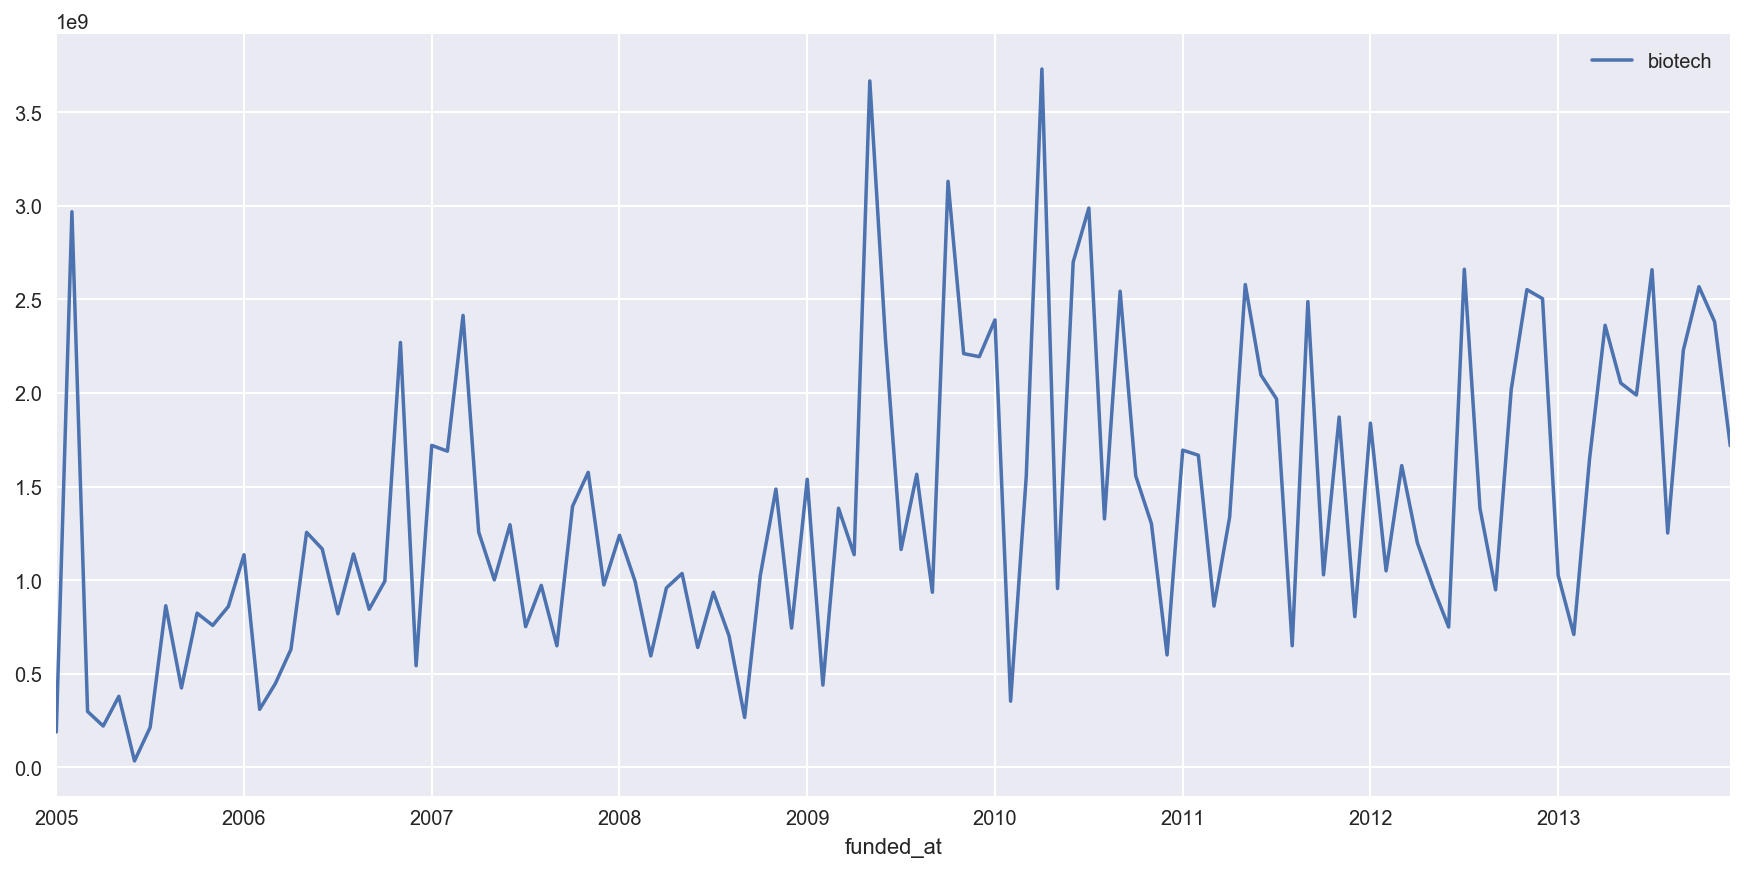

In [70]:
time_line.plot(x='funded_at', y=['biotech'], figsize=(15,7))

# Let me see if you can RUN IT, RUN IT

In [6]:
# Just checking to see what gaps are in the data. Seems that about 3700 companies don't have complete funding info 
# from one crunchbase file to another... Great! Let's keep moving anyway

money_columns = []
for i in df.columns:
    if 'raised_amount_usd' in i:
        money_columns.append(i)


df['my_sum'] = df[money_columns].sum(axis=1)
df['difference'] = df['my_sum'] - df['funding_total_usd']

### Histograms Look similar (enough)

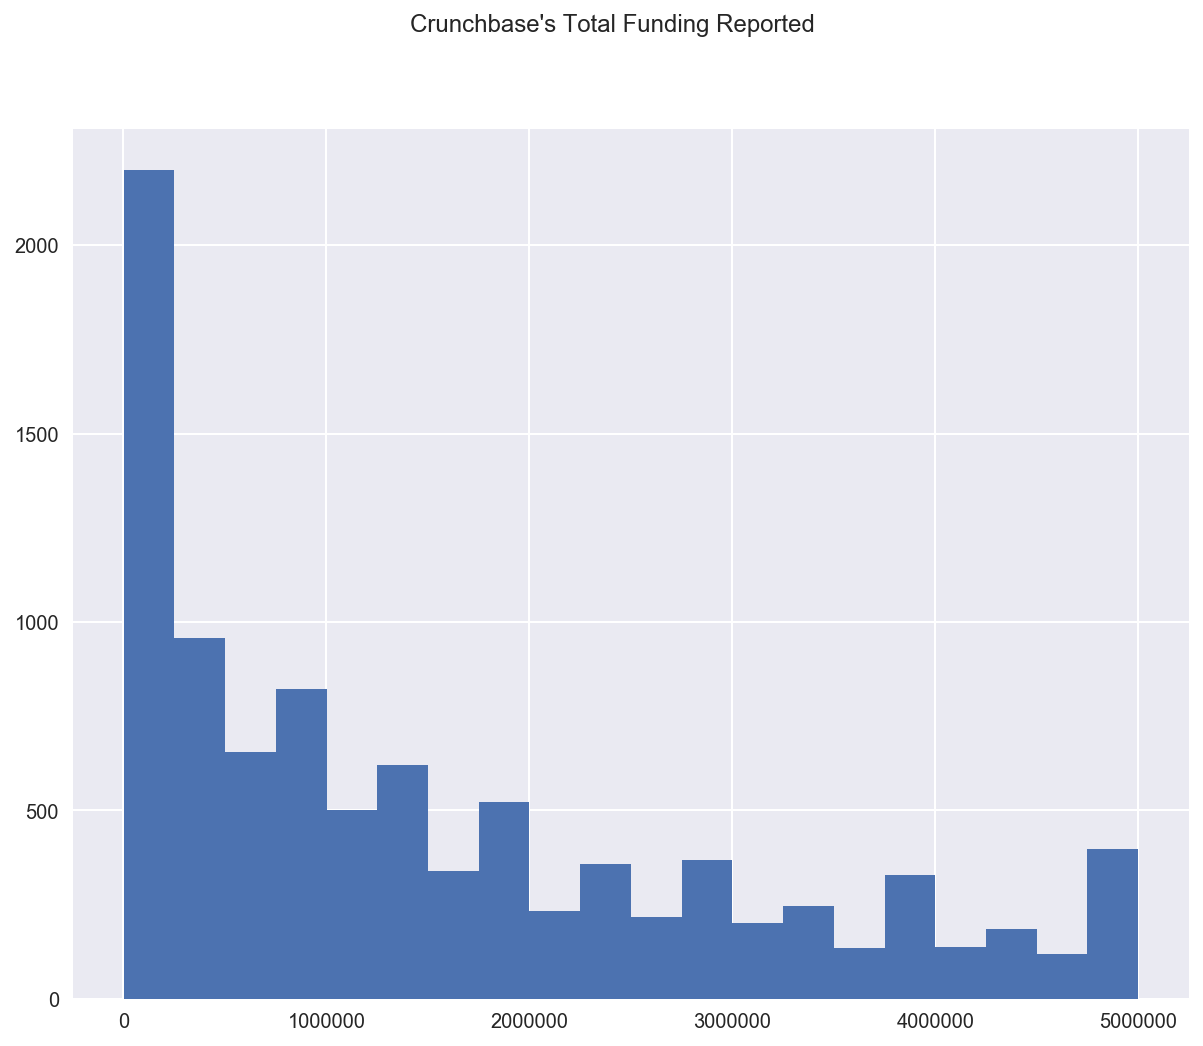

In [9]:
df[df['funding_total_usd'] <= 5000000].funding_total_usd.hist(figsize=(10,8), bins=20)
plt.suptitle("Crunchbase's Total Funding Reported")

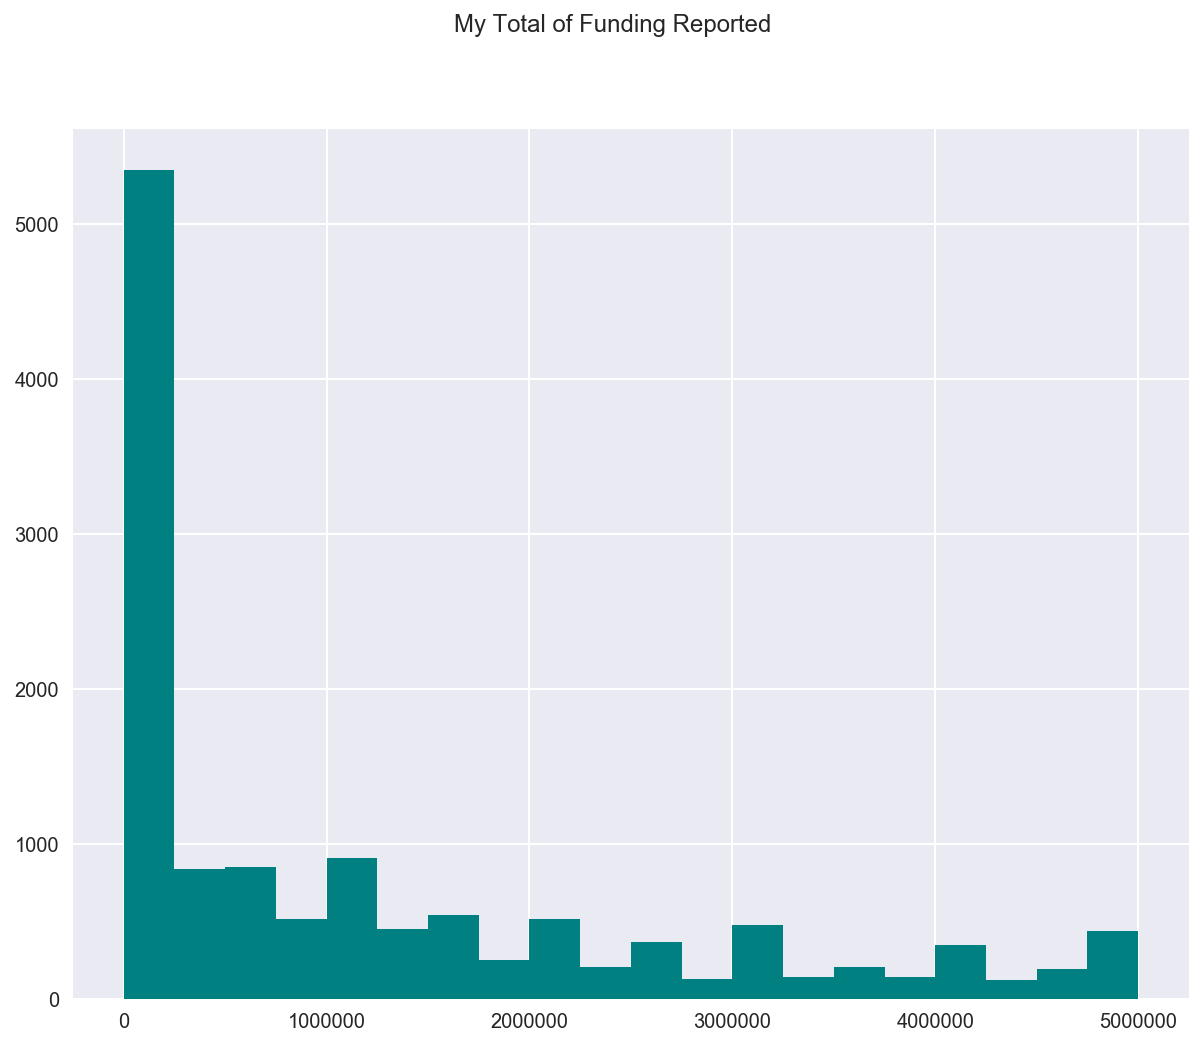

In [26]:
df[df['my_sum'] <= 5000000].my_sum.hist(color='teal', figsize=(10,8), bins=20)
plt.suptitle("My Total of Funding Reported")

In [40]:
# To probably be used later on
successful = df[(df['status'] == 'ipo') | (df['status'] == 'acquired')]
failure = df[df['status'] == 'closed']

data_cleaning = df[['raised_amount_usd_angel', 'raised_amount_usd_seed', 'raised_amount_usd_a', 'raised_amount_usd_b', 
         'raised_amount_usd_c', 'raised_amount_usd_series_d_above', 'raised_amount_usd_secondary_market', 
         'raised_amount_usd_series_unknown', 'raised_amount_usd_other']]

data_cleaning = data_cleaning.apply(lambda x: np.log1p(x))

In [42]:
# # CAREFUL! This will take a little bit. Not too long though... 
# # Some linear relationships can be inferred between some rounds. Mostly art and blobs though.
# scatter_matrix(data_cleaning, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [52]:
def correlation_heat_map(df):
    corrs = df.corr()
    
    # set figure size
    fig, ax = plt.subplots(figsize = (18, 13))
    
    #generate a mask for the upper triangle
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, annot=True)
    
    #resize labels
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    
    plt.show()

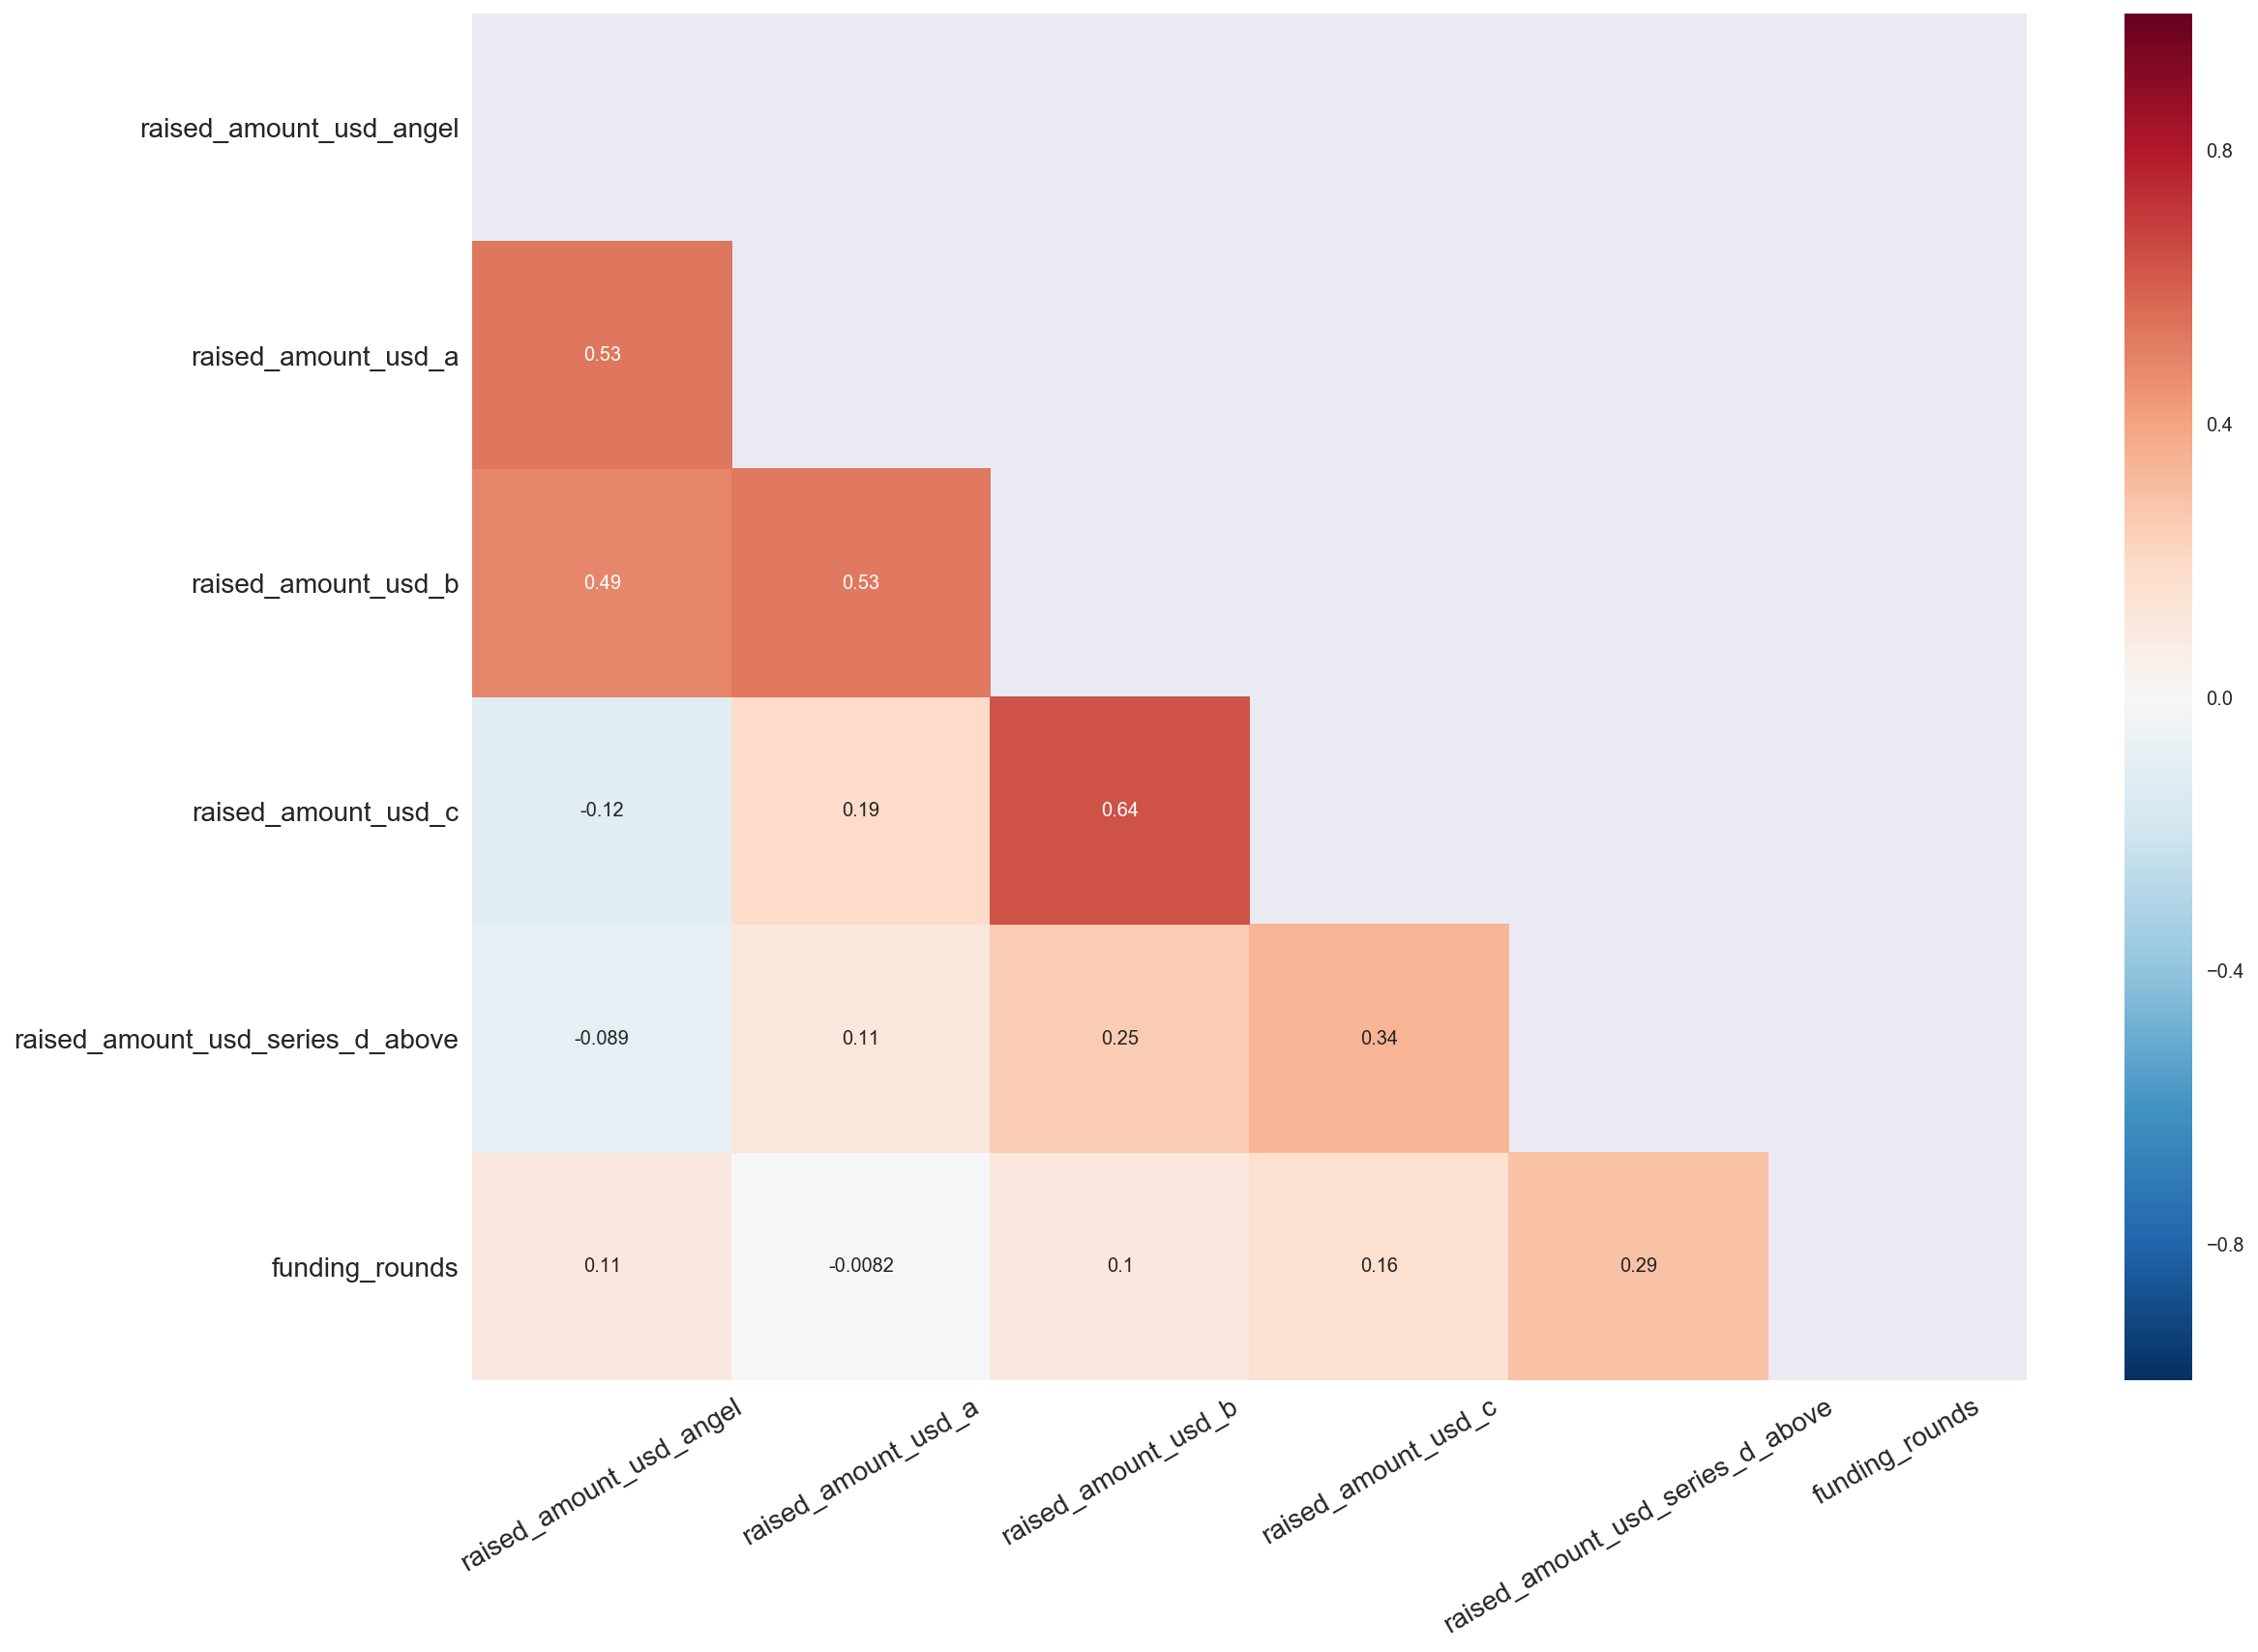

In [53]:
correlation_heat_map(df[['raised_amount_usd_angel', 'raised_amount_usd_a', 'raised_amount_usd_b', 'raised_amount_usd_c', 'raised_amount_usd_series_d_above', 'funding_rounds']])


## Good ole Heatmap
- I was kind of hoping that the diagonal (which is the relative current round with the relative previous round) would have darker colors. That's okay because a lot of these are decently positve.
- However, this makes a lot of sense because if you get a 10 million in Series A funding then you're likely to get more funding in Series B.

## Next up: Histograms At Different Stages
- Lots of pictures. Yet, I think some numbers would be more useful as they're all so positively skewed.
- Throughout most of the categories, the max for each hangs out around 100 Millions (ranging from 1 to 9.5 x 10^8).
- However, the averages (and medians) move a nice way. 
 - Series A: 7.6 (4.4) Million
 - Series B: 13 (10) Million
 - Series C: 19.7 (14) Million
 - Series D (and above): 35 (20) Million

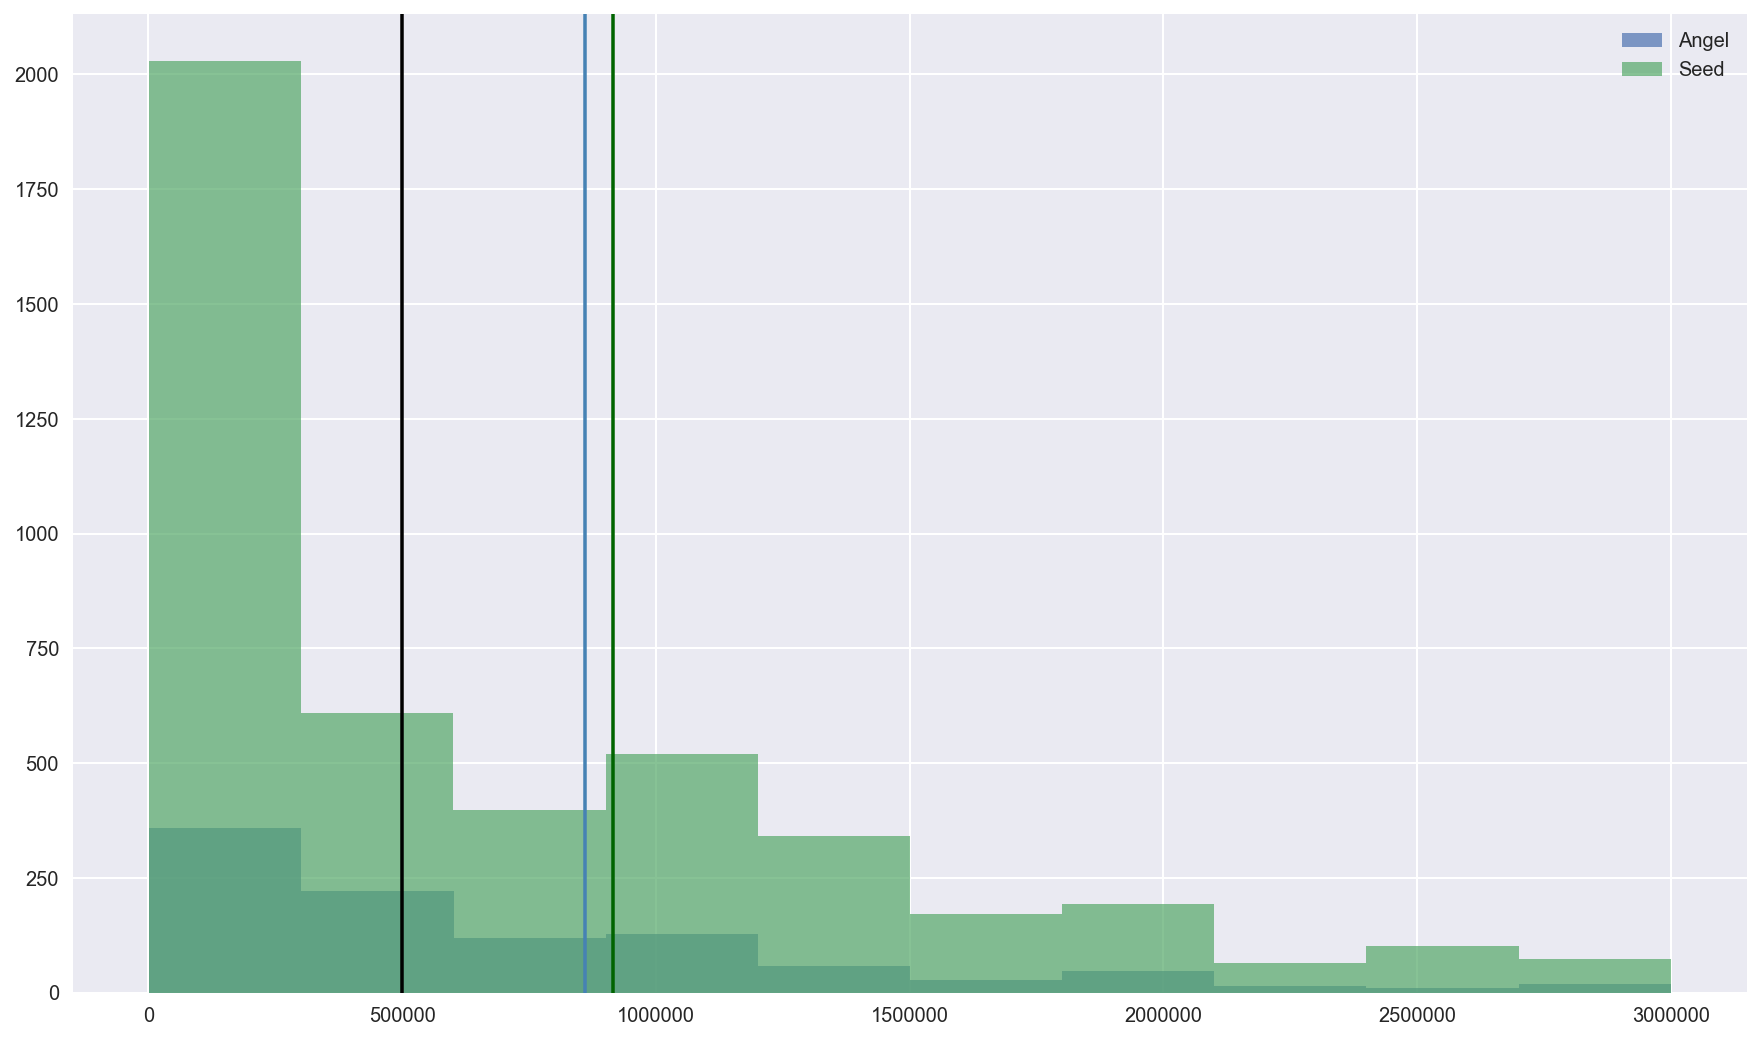

In [47]:
angel_ = df[df['raised_amount_usd_angel'] <= 3000000].raised_amount_usd_angel.values
seed_ = df[df['raised_amount_usd_seed'] <= 3000000].raised_amount_usd_seed.values

plt.figure(figsize=(15,9))
plt.hist(angel_, bins=10, alpha=0.7, label='Angel',)
plt.hist(seed_, bins=10, alpha=0.7, label='Seed')
plt.legend(loc='upper right')
plt.axvline(df.raised_amount_usd_angel.mean(), color='steelblue')
plt.axvline(df.raised_amount_usd_seed.mean(), color='darkgreen')
plt.axvline(df.raised_amount_usd_seed.median(), color='black')
plt.show()

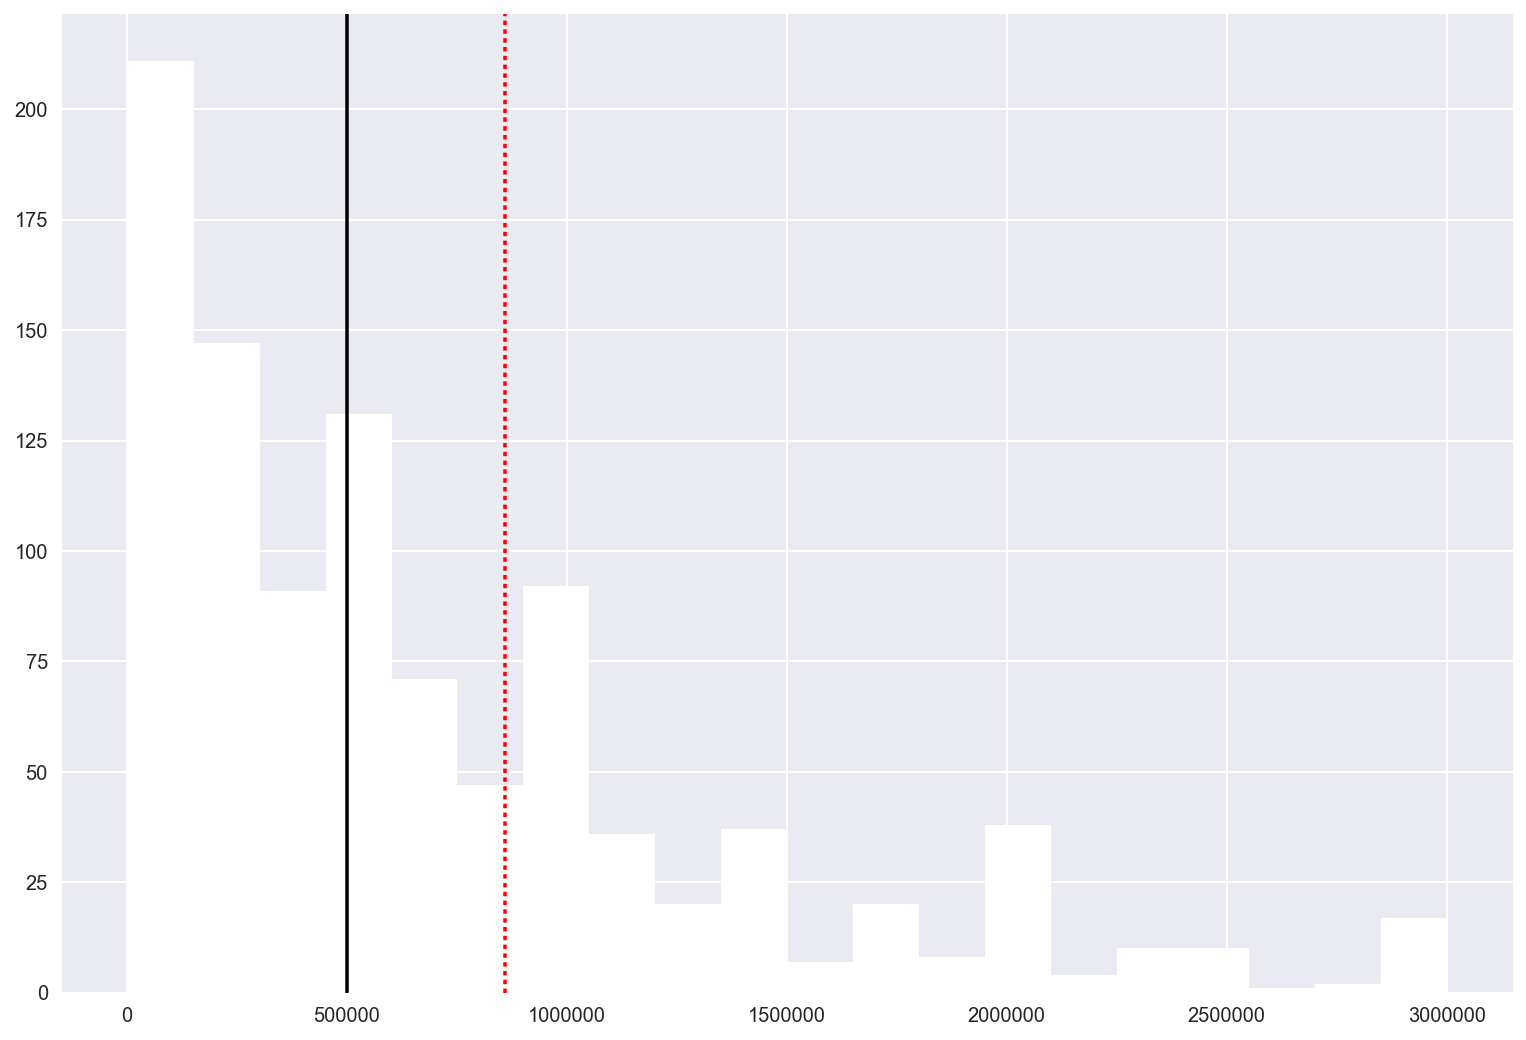

In [12]:
# Angel < 3 million
ax_angel = df[df['raised_amount_usd_angel'] <= 3000000].raised_amount_usd_angel.hist(color='white', figsize=(13,9), bins=20)
ax_angel.axvline(df.raised_amount_usd_angel.median(), color='black')
ax_angel.axvline(df.raised_amount_usd_angel.mean(), color='red', ls='dotted')

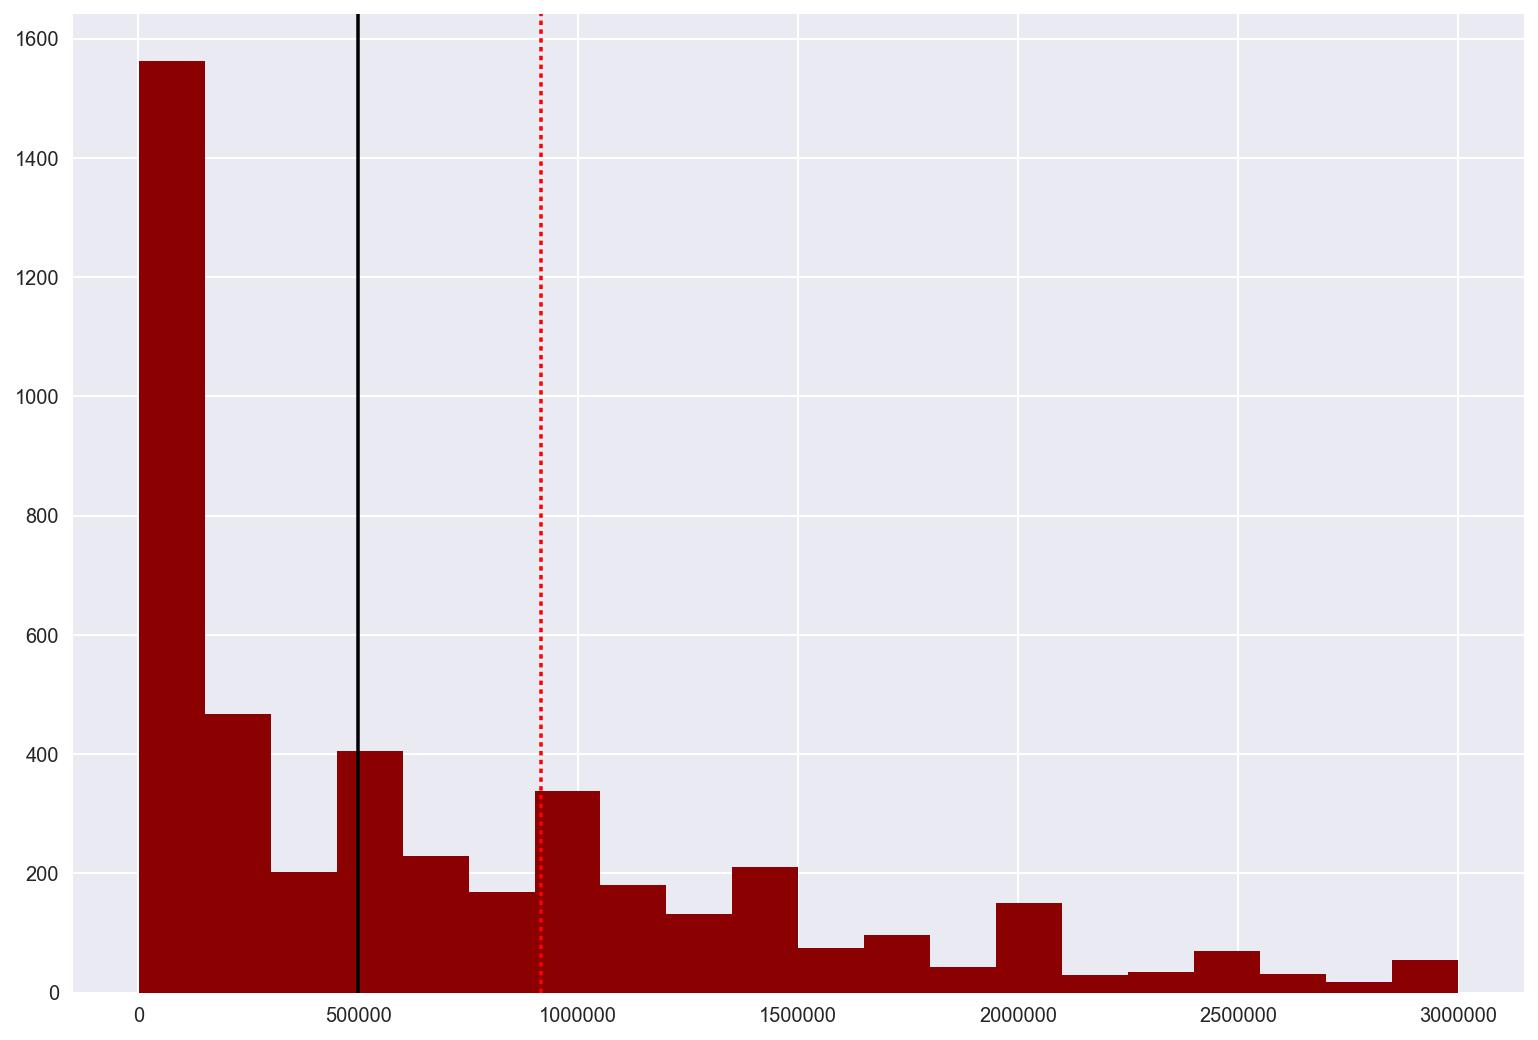

In [13]:
# Seed < 3 million
ax_seed = df[df['raised_amount_usd_seed'] <= 3000000].raised_amount_usd_seed.hist(color='darkred', figsize=(13,9), bins=20)
ax_seed.axvline(df.raised_amount_usd_seed.median(), color='black')
ax_seed.axvline(df.raised_amount_usd_seed.mean(), color='red', ls='dotted')

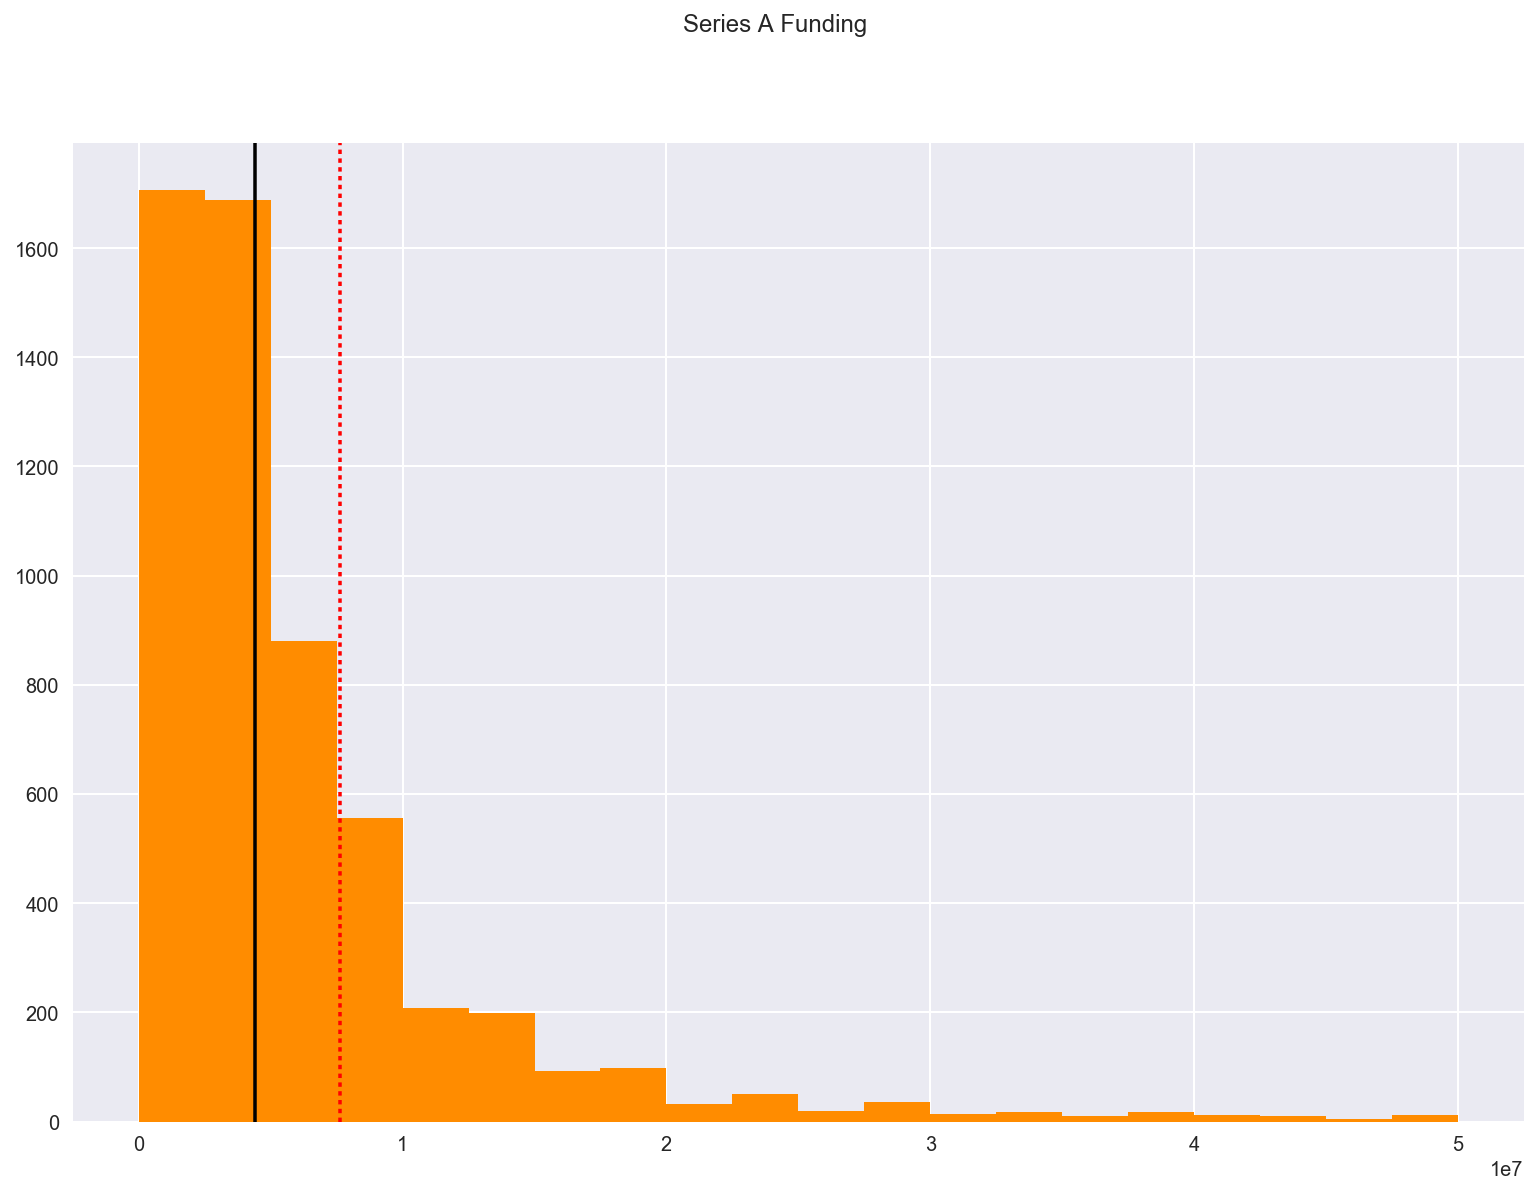

In [139]:
# A < 50 million
ax_a = df[df['raised_amount_usd_a'] <= 50000000].raised_amount_usd_a.hist(color='darkorange', figsize=(13,9), bins=20)
ax_a.axvline(df.raised_amount_usd_a.median(), color='black')
ax_a.axvline(df.raised_amount_usd_a.mean(), color='red', ls='dotted')
plt.suptitle("Series A Funding")

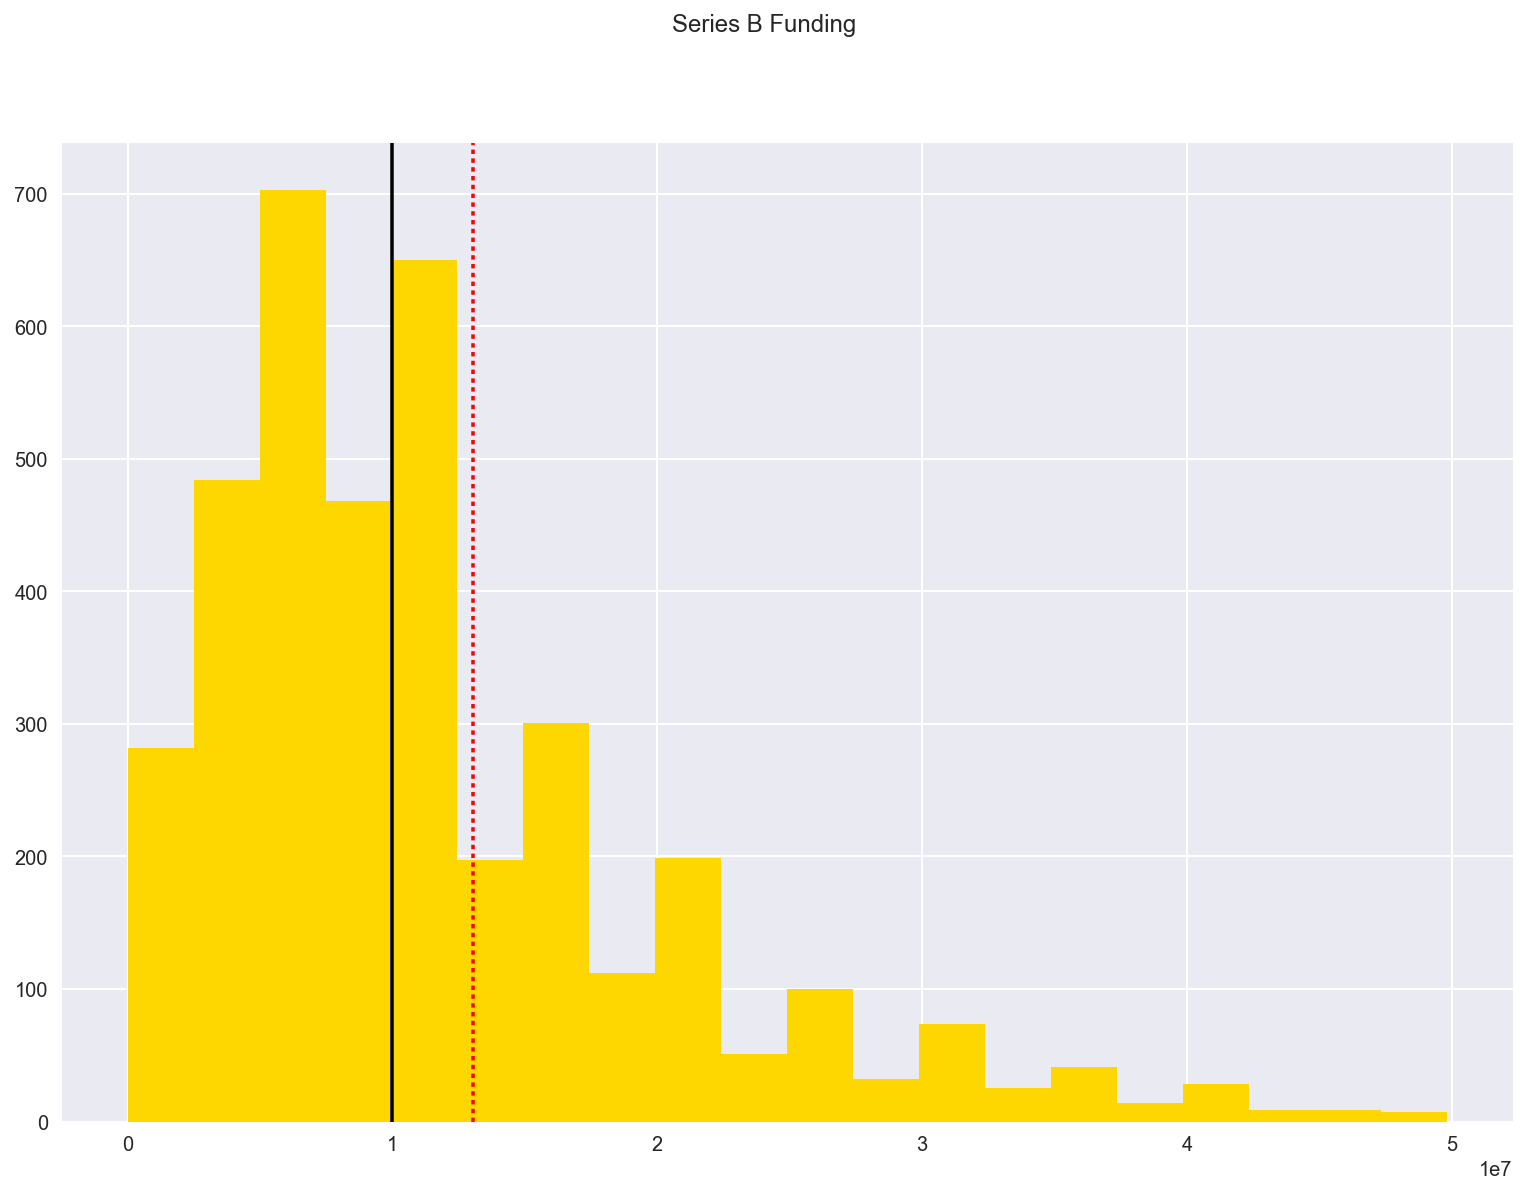

In [48]:
# B < 50 million
ax_b = df[df['raised_amount_usd_b'] <= 50000000].raised_amount_usd_b.hist(color='gold', figsize=(13,9), bins=20)
ax_b.axvline(df.raised_amount_usd_b.median(), color='black')
ax_b.axvline(df.raised_amount_usd_b.mean(), color='red', ls='dotted')
plt.suptitle("Series B Funding")

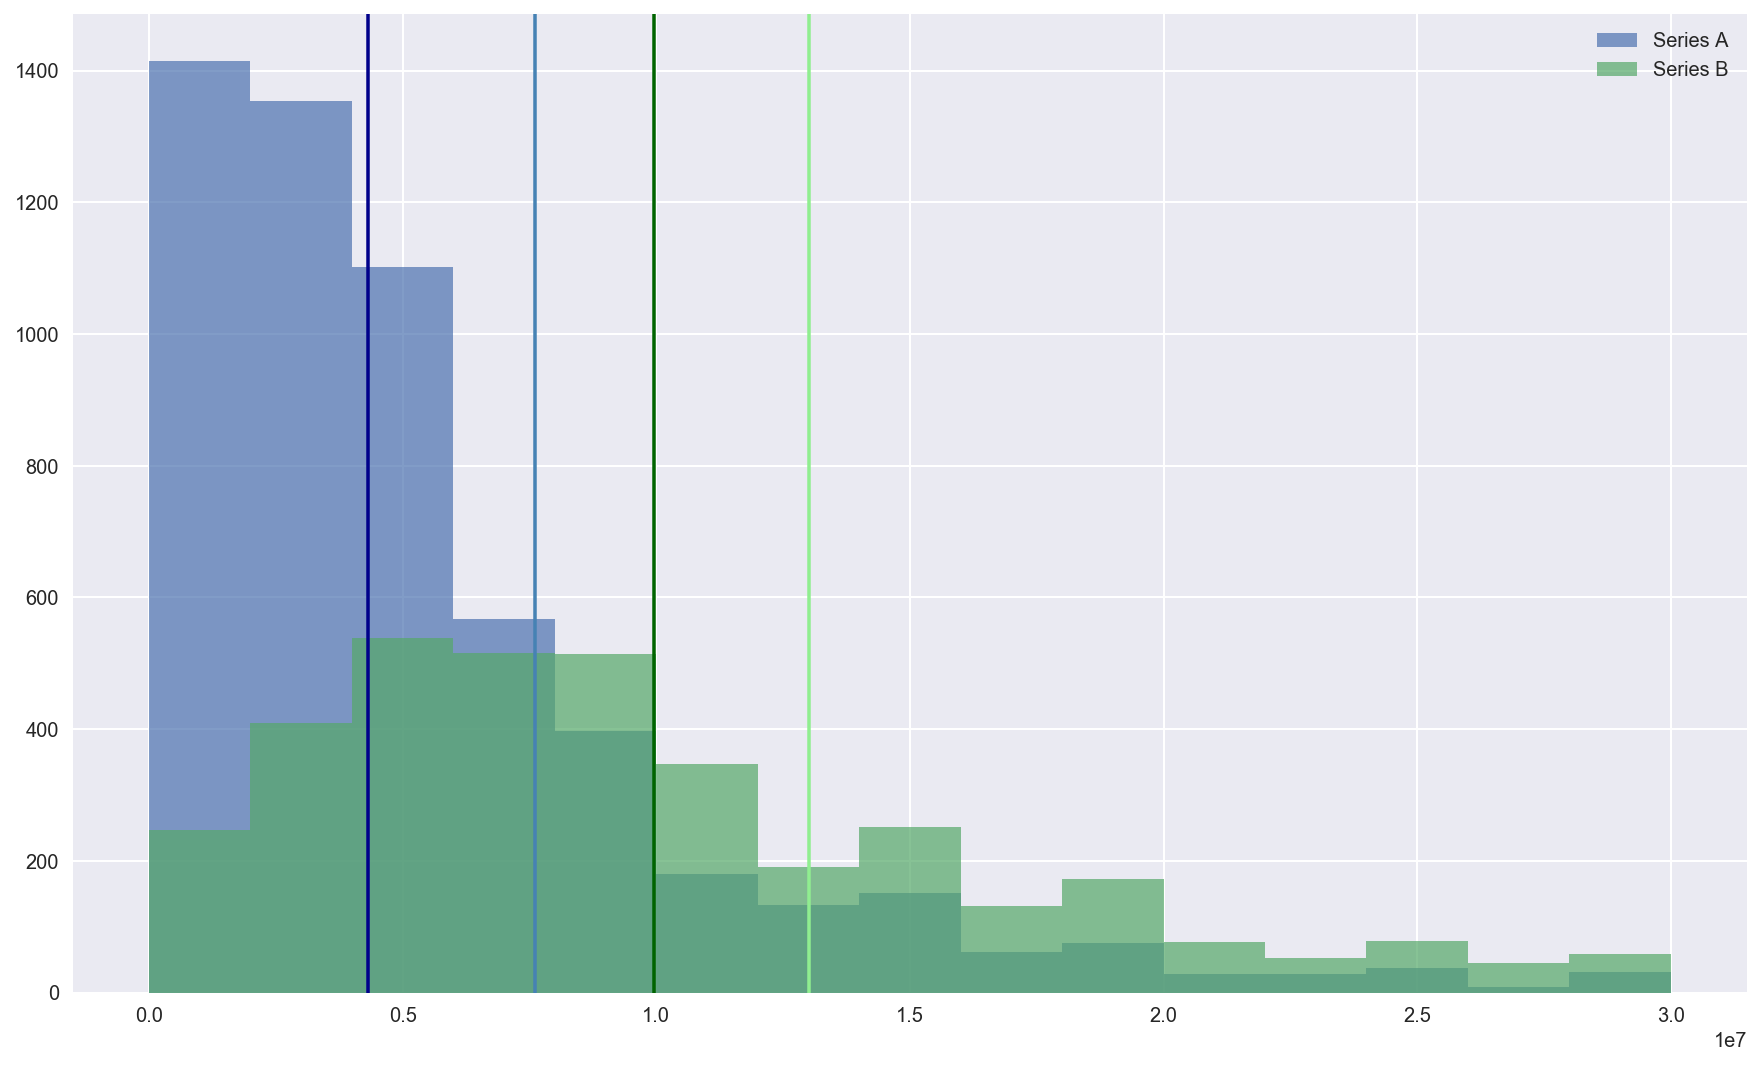

In [44]:
a_ = df[df['raised_amount_usd_a'] <= 30000000].raised_amount_usd_a.values
b_ = df[df['raised_amount_usd_b'] <= 30000000].raised_amount_usd_b.values

plt.figure(figsize=(15,9))
plt.hist(a_, bins=15, alpha=0.7, label='Series A',)
plt.hist(b_, bins=15, alpha=0.7, label='Series B')
plt.legend(loc='upper right')
plt.axvline(df.raised_amount_usd_a.mean(), color='steelblue')
plt.axvline(df.raised_amount_usd_b.mean(), color='lightgreen')
plt.axvline(df.raised_amount_usd_a.median(), color='darkblue')
plt.axvline(df.raised_amount_usd_b.median(), color='darkgreen')
plt.show()

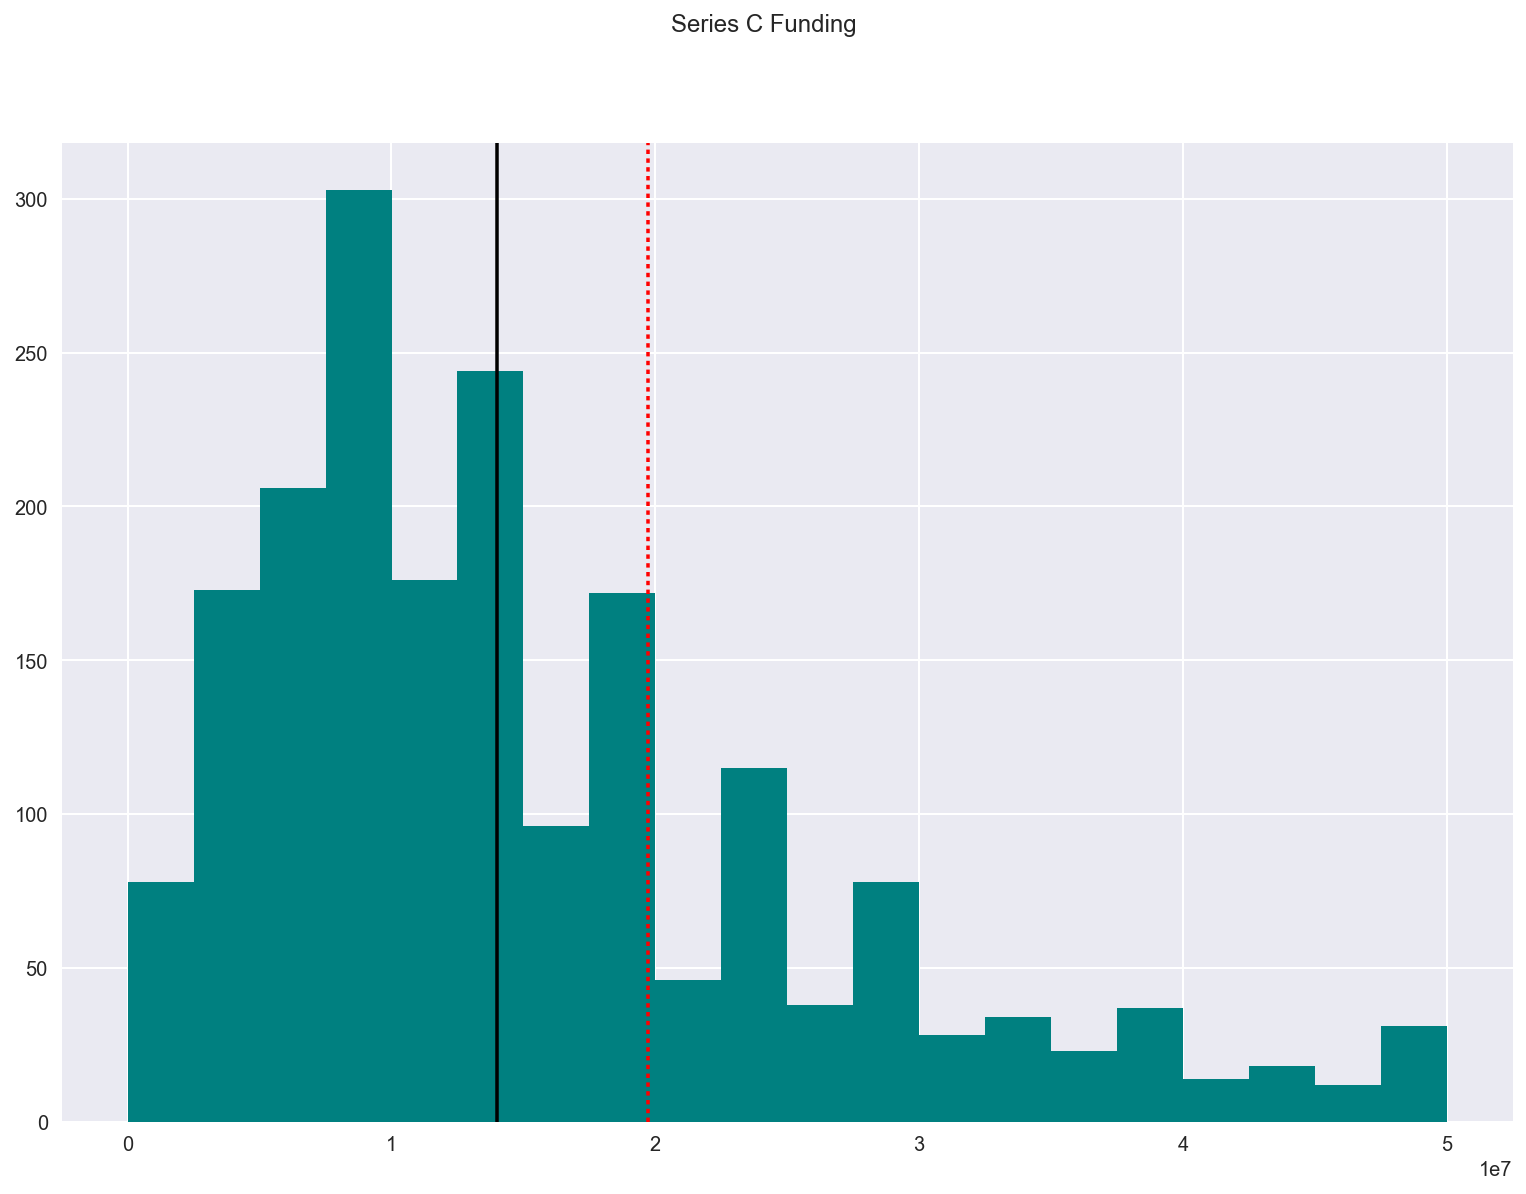

In [137]:
# C < 50 million
ax_c = df[df['raised_amount_usd_c'] <= 50000000].raised_amount_usd_c.hist(color='teal', figsize=(13,9), bins=20)
ax_c.axvline(df.raised_amount_usd_c.median(), color='black')
ax_c.axvline(df.raised_amount_usd_c.mean(), color='red', ls='dotted')
plt.suptitle("Series C Funding")

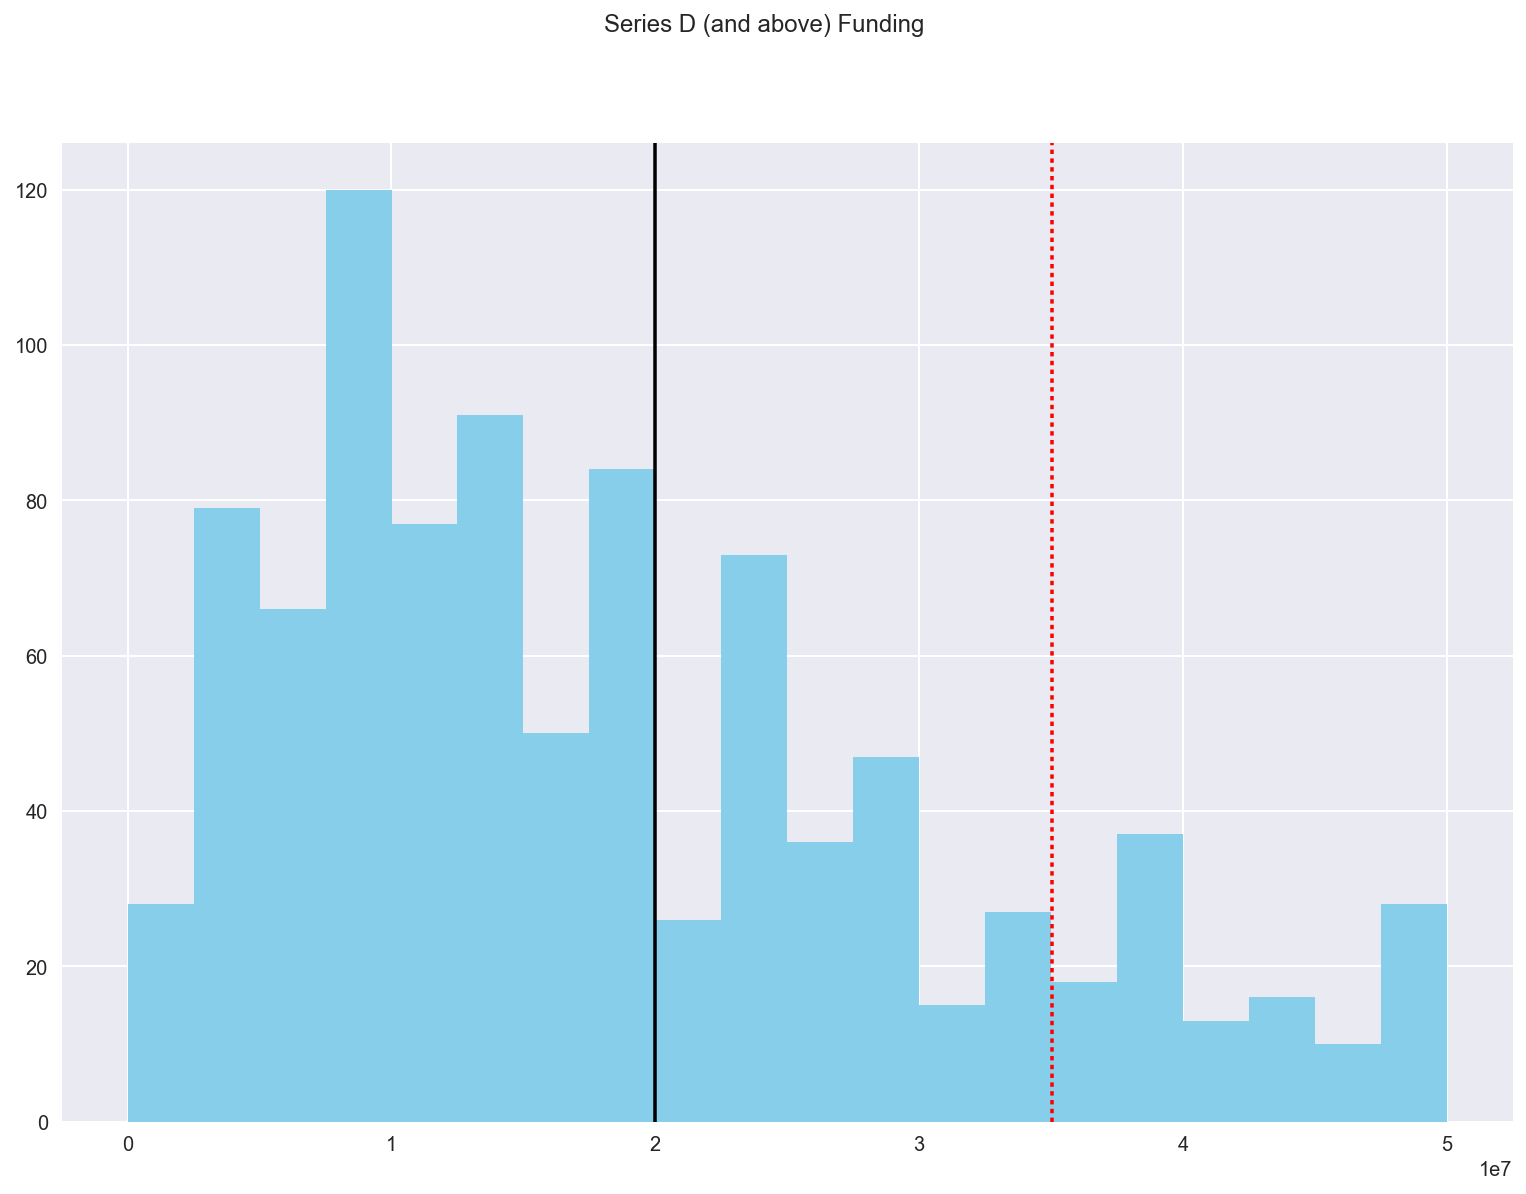

In [138]:
# D < 50 million
ax_d = df[df['raised_amount_usd_series_d_above'] <= 50000000].raised_amount_usd_series_d_above.hist(color='skyblue', figsize=(13,9), bins=20)
ax_d.axvline(df.raised_amount_usd_series_d_above.median(), color='black')
ax_d.axvline(df.raised_amount_usd_series_d_above.mean(), color='red', ls='dotted')
plt.suptitle("Series D (and above) Funding")

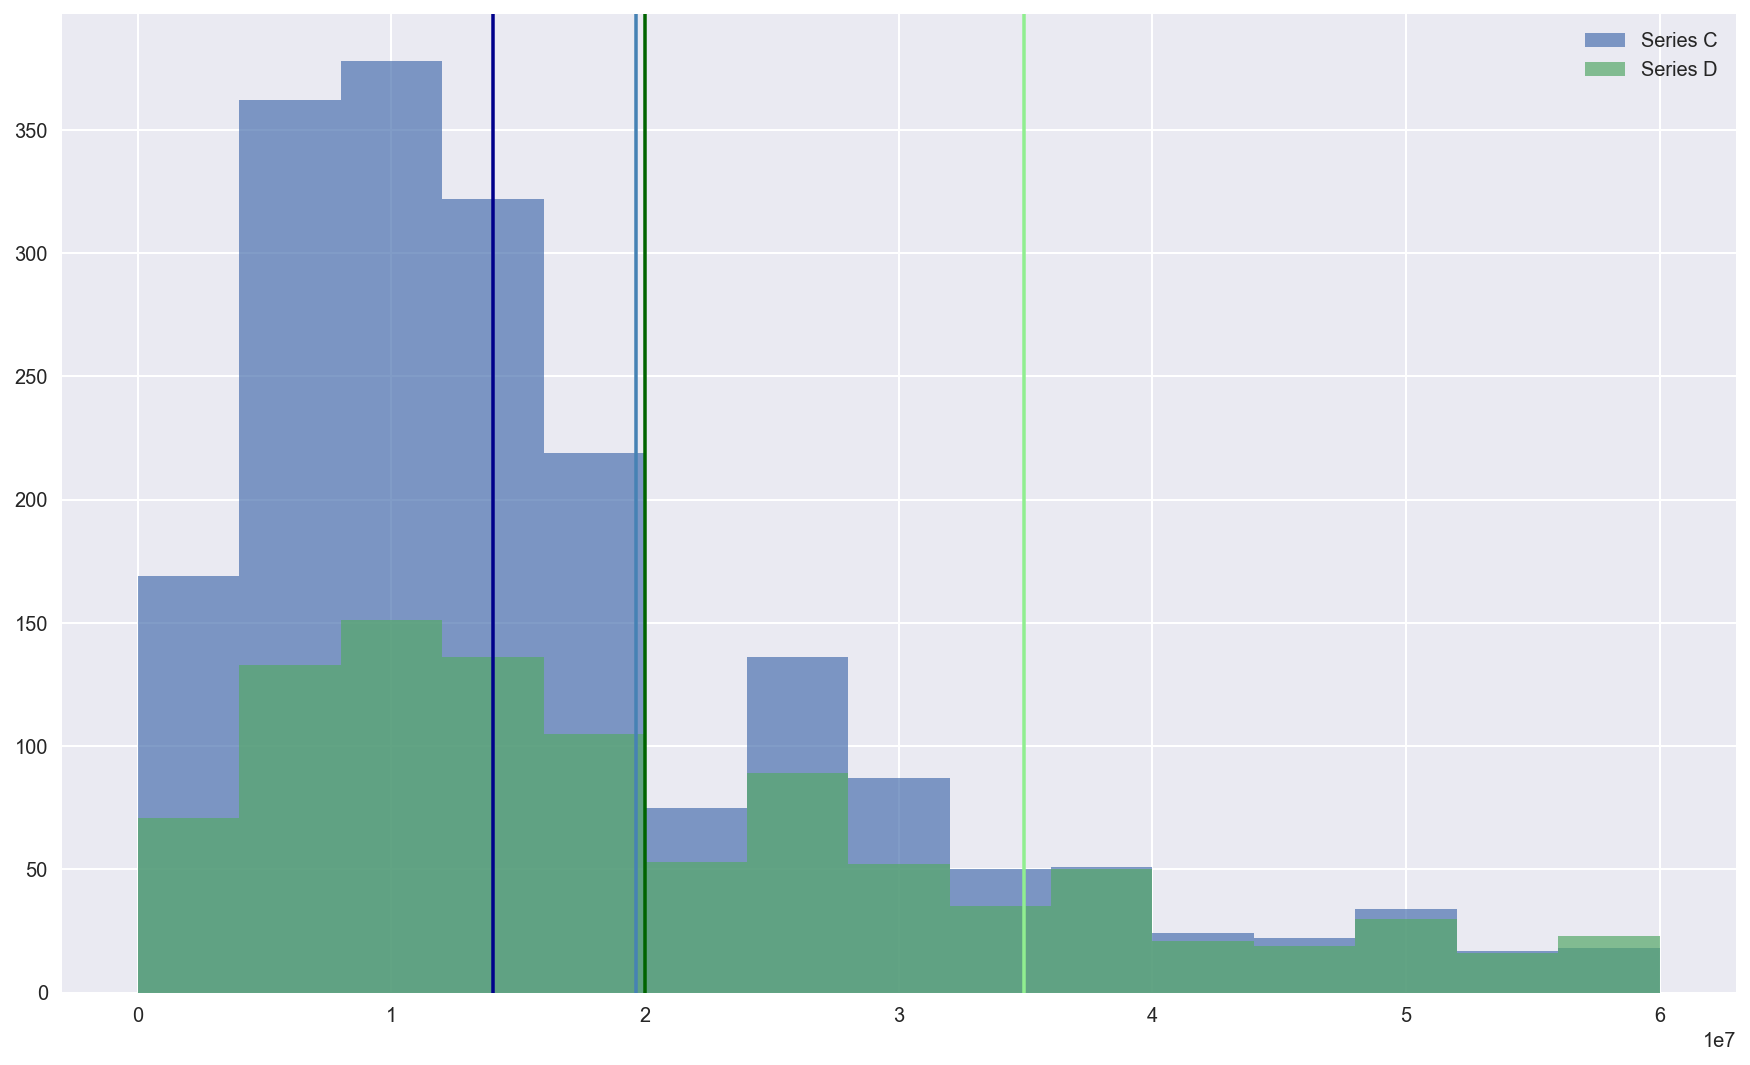

In [43]:
c_ = df[df['raised_amount_usd_c'] <= 60000000].raised_amount_usd_c.values
d_ = df[df['raised_amount_usd_series_d_above'] <= 60000000].raised_amount_usd_series_d_above.values

plt.figure(figsize=(15,9))
plt.hist(c_, bins=15, alpha=0.7, label='Series C',)
plt.hist(d_, bins=15, alpha=0.7, label='Series D')
plt.legend(loc='upper right')
plt.axvline(df.raised_amount_usd_c.mean(), color='steelblue')
plt.axvline(df.raised_amount_usd_series_d_above.mean(), color='lightgreen')
plt.axvline(df.raised_amount_usd_c.median(), color='darkblue')
plt.axvline(df.raised_amount_usd_series_d_above.median(), color='darkgreen')
plt.show()

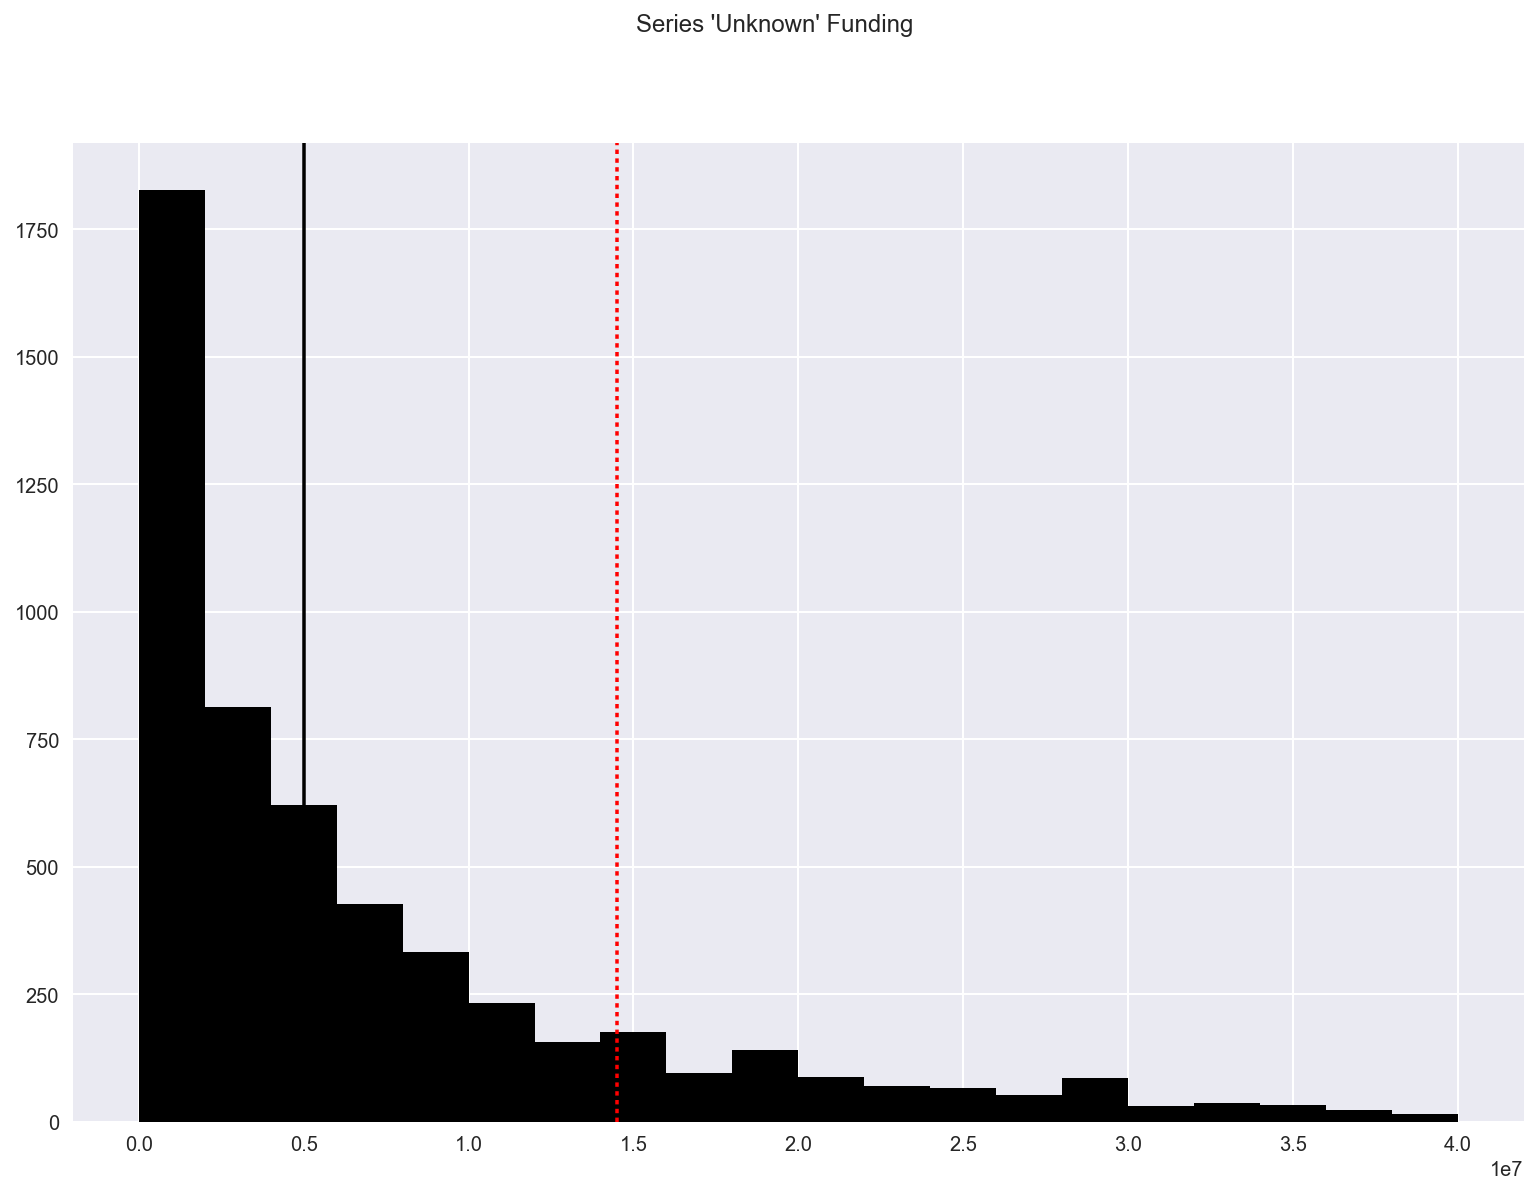

In [51]:
# Unknown < 40 million
ax_u =df[df['raised_amount_usd_series_unknown'] <= 40000000].raised_amount_usd_series_unknown.hist(color='black', figsize=(13,9), bins=20)
ax_u.axvline(df.raised_amount_usd_series_unknown.median(), color='black')
ax_u.axvline(df.raised_amount_usd_series_unknown.mean(), color='red', ls='dotted')
plt.suptitle("Series 'Unknown' Funding")

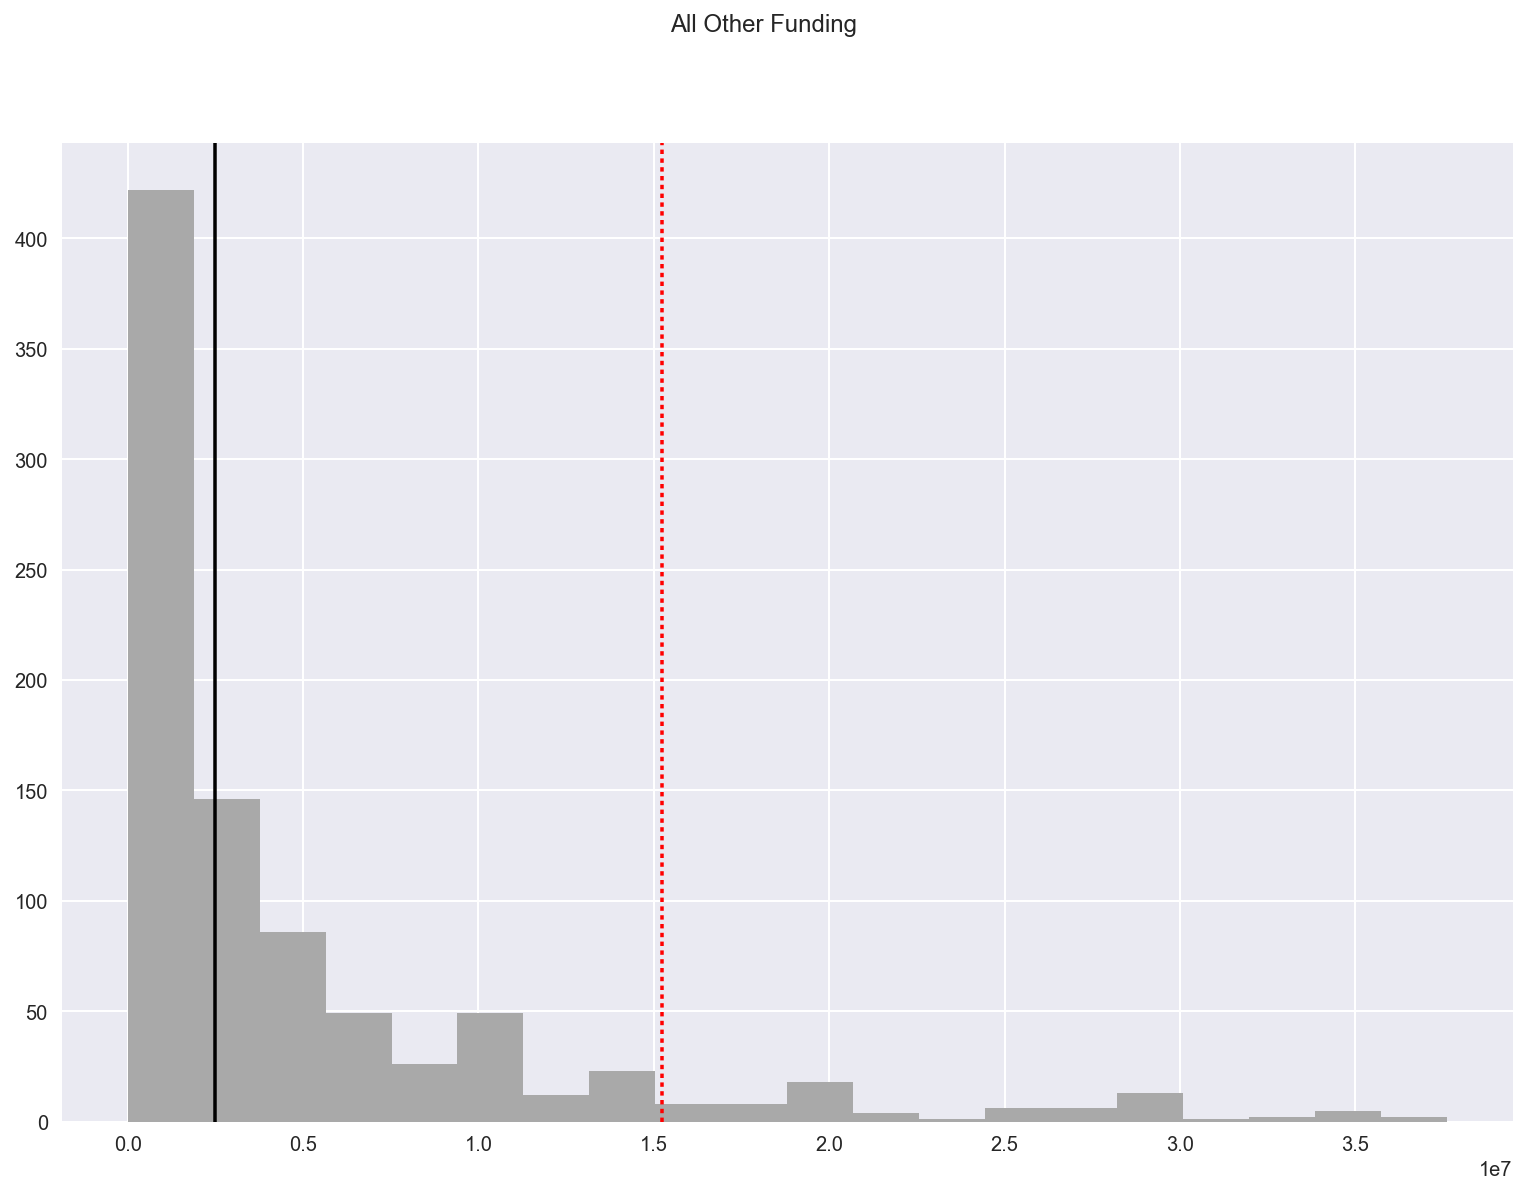

In [52]:
# Other < 40 million
ax_o = df[df['raised_amount_usd_other'] <= 40000000].raised_amount_usd_other.hist(bins=20, color='darkgrey', figsize=(13,9))
ax_o.axvline(df.raised_amount_usd_other.median(), color='black')
ax_o.axvline(df.raised_amount_usd_other.mean(), color='red', ls='dotted')
plt.suptitle("All Other Funding")

## Next Up: Bar Graphs of Top Investors in the Early Stages

#### Starting with Angel Investors

In [ ]:
investors_angel = ['investor_object_id', 'category_code_angel']
df_angels = df_all_sectors[investors_angel]

# Looping through Series D investors: This empty list becomes all the unique investors for Series D
category_code_list_angel = []
for angel in df_angels['category_code_angel'].unique().tolist():
    if angel != None:
        for i in angel:
            if i in category_code_list_angel:
                pass
            else:
                category_code_list_angel.append(i)

# From the unique set of investors, let's add those as new columns to this subset dataframe
unique_category = set(category_code_list_angel)
for c in unique_category:
    column_name = "Angel_" + str(c)
    df_angels[column_name] = np.zeros(len(df_sector), dtype=np.int8)

# Now we're finally doing this one hot encoding thing for each investor found in the Series D round
for i, c in enumerate(df_angels.category_code_angel):
    try:
        for category in c:
            column_name = "Angel_" + str(category)
            df_angels.ix[i, column_name] += 1
    except:
        pass

df0 = df_angels.dropna()
df0 = df0.reset_index()
del df0['index']

angellist = []
for i in df0.columns:
    if 'Angel_' in i:
        angellist.append(i)

df0['angel_commmitments'] = df0[angellist].sum(axis=1)

only_angels = df0.merge(df_objects, left_on='investor_object_id', right_on='id')
del only_angels['id']

top_angels = only_angels[only_angels['angel_commmitments'] >= 8].sort_values(by='angel_commmitments')

In [ ]:
top_angels.plot.barh(x='name', y='angel_commmitments', color='white', figsize=(13,9))

#### Now onto Top Seed Stages Investors

In [ ]:
investors_seed = ['investor_object_id', 'category_code_seed']
df_seed = df_all_sectors[investors_seed]

# Looping through Series D investors: This empty list becomes all the unique investors for Series D
category_code_list_seed = []
for row in df_seed['category_code_seed'].unique().tolist():
    if row != None:
        for i in row:
            if i in category_code_list_seed:
                pass
            else:
                category_code_list_seed.append(i)

# From the unique set of investors, let's add those as new columns to this subset dataframe
unique_category = set(category_code_list_seed)
for c in unique_category:
    column_name = "Seed_" + str(c)
    df_seed[column_name] = np.zeros(len(df_all_sectors), dtype=np.int8)

# Now we're finally doing this one hot encoding thing for each investor found in the Series D round
for i, c in enumerate(df_seed.category_code_seed):
    try:
        for category in c:
            column_name = "Seed_" + str(category)
            df_seed.ix[i, column_name] += 1
    except:
        pass


df1 = df_seed.dropna()
df1 = df1.reset_index()
del df1['index']

seed_list = []
for i in df1.columns:
    if 'Seed_' in i:
        seed_list.append(i)

df1['seed_commmitments'] = df1[seed_list].sum(axis=1)

only_seed = df1.merge(df_objects, left_on='investor_object_id', right_on='id')
del only_seed['id']

top_seed = only_seed[only_seed['seed_commmitments'] >= 38].sort_values(by='seed_commmitments')

In [ ]:
# Plotting top Seed stage investors
top_seed.plot.barh(x='name', y='seed_commmitments', color='darkred', figsize=(13,9))

#### We'll stop at top Series A Investors

In [41]:
investors_a = ['investor_object_id', 'category_code_a']
df_a = df_all_sectors[investors_a]

# From the unique set of investors, let's add those as new columns to this subset dataframe
unique_category = set(category_code_list_seed)
for c in unique_category:
    column_name = "A_" + str(c)
    df_a[column_name] = np.zeros(len(df_all_sectors), dtype=np.int8)

# Now we're finally doing this one hot encoding thing for each investor found in the Series D round
for i, c in enumerate(df_a.category_code_a):
    try:
        for category in c:
            column_name = "A_" + str(category)
            df_a.ix[i, column_name] += 1
    except:
        pass


df2 = df_a.dropna()
df2 = df2.reset_index()
del df2['index']

a_list = []
for i in df2.columns:
    if 'A_' in i:
        a_list.append(i)

df2['series_a_commmitments'] = df2[a_list].sum(axis=1)

only_a = df2.merge(df_objects, left_on='investor_object_id', right_on='id')
del only_a['id']

top_series_a = only_a[only_a['series_a_commmitments'] >= 51].sort_values(by='series_a_commmitments')

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


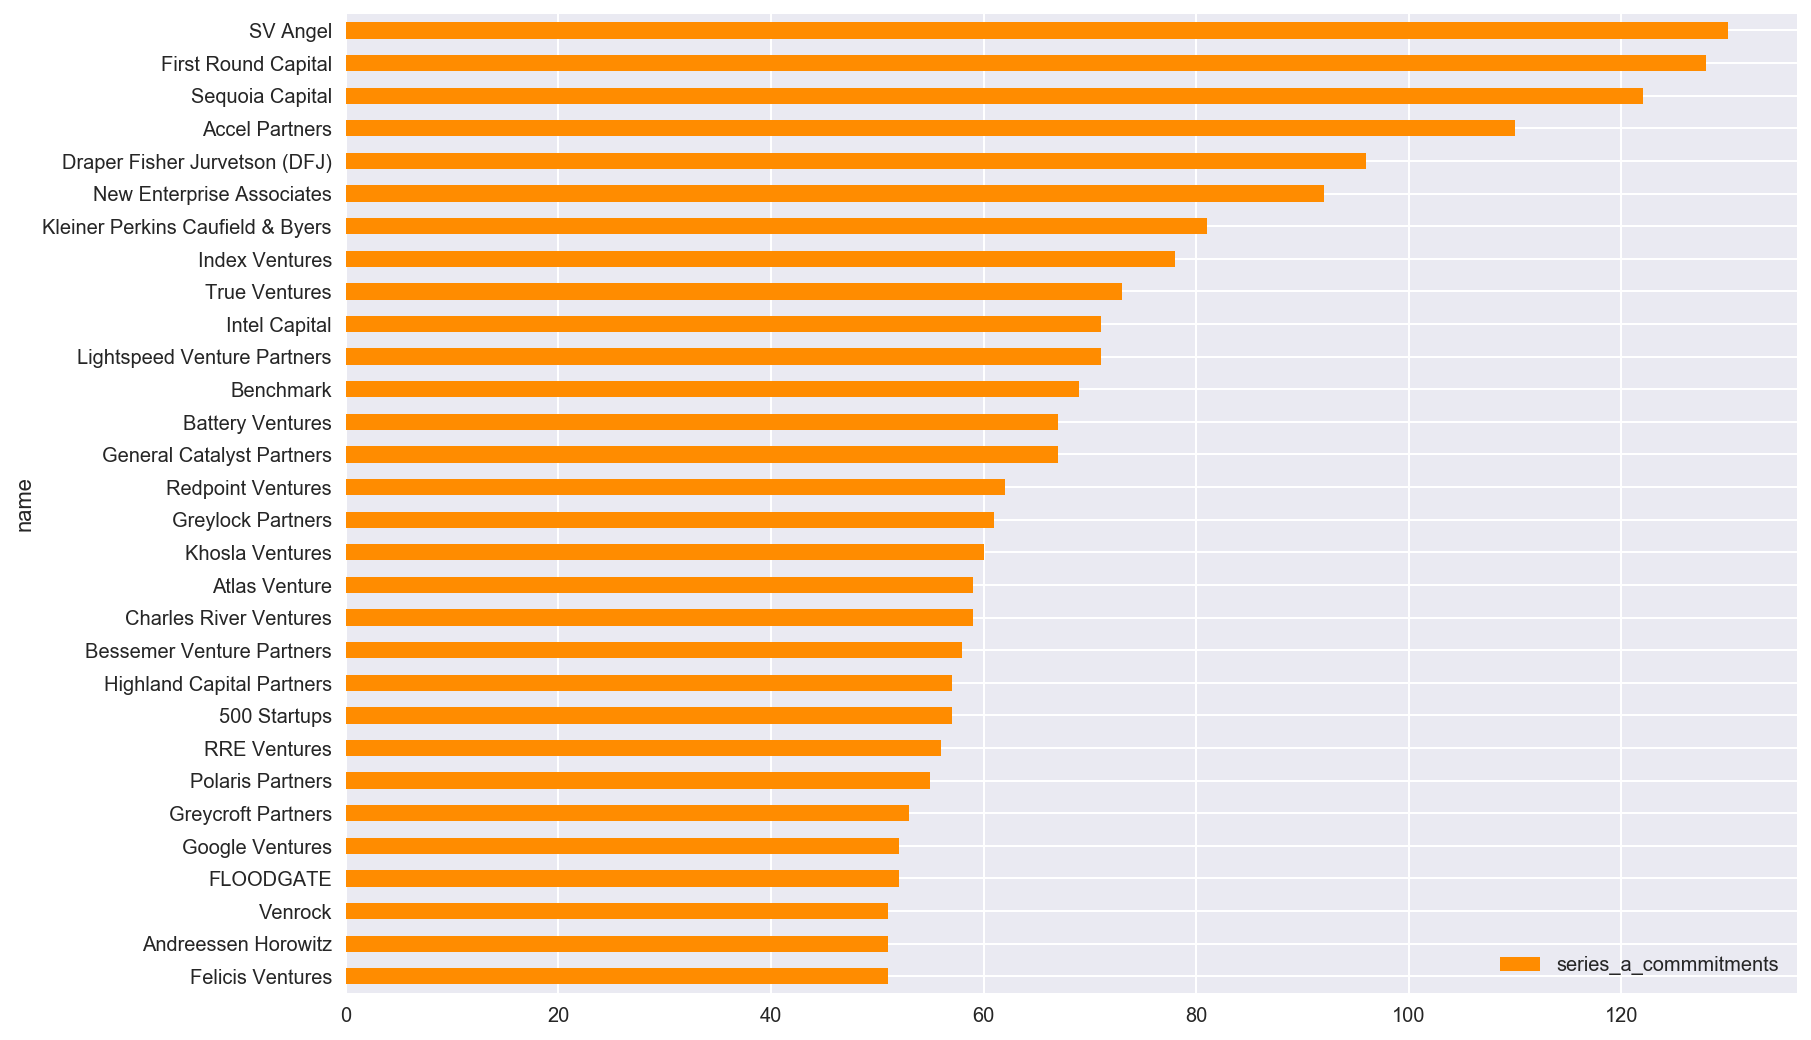

In [42]:
# Plotting top Seed stage investors
top_series_a.plot.barh(x='name', y='series_a_commmitments', color='darkorange', figsize=(13,9))

In [72]:
df[(df['raised_amount_usd_a'] > 0) &
   (df['raised_amount_usd_b'].isnull()) & 
   (df['status'] == 'ipo') & 
   (df['raised_amount_usd_c'].isnull()) & 
   (df['raised_amount_usd_series_d_above'].isnull()) & 
   (df.raised_amount_usd_series_unknown.isnull()) & 
   (df.raised_amount_usd_other.isnull())].category_code.value_counts()

network_hosting    3
cleantech          2
biotech            2
search             2
ecommerce          1
mobile             1
enterprise         1
web                1
Name: category_code, dtype: int64

## The State of the Unity
As much as I want to run a model. I've realized a major constraint within my data. I'm looking at very correlated data... And not much signal can be derived from these features. Another issue is that a relationship between two variables being linear could signal different things. 

#### Time Between Rounds
- As in, a company gets Series A funding and then receives Series B funding **quickly** thereafter. One case could be that they're growing so quickly that they need the cash in order to keep that growth. Another case could be that they couldn't manage their Series A funding well and need Series B quickly.
- Within this timing example, a **long time** between rounds also doesn't quite give a signal either way. As in, they've grown steadily for a long time and need Series B for the next stage. Or, it could be they've grown steadily but growing at a deficit...

Essentially, I have how much, when (with time between when they got funds), outcome (acquired/ipo/closed) and sector of that company (software, biotech etc) and (as of now) useless tuple of investors. 

#### Number of Investors
- I'm going to make a number of investors for a given round yet see this as also having a signal issue
 - As in, a lot of investors want in for a *nearly certain* win **OR** a lot of investors are part of the deal because they're uncertain if this thing will actually take off thus are hedging their bets.
 - An interesting finding confirms one of my expectations. For each Series round, I found the unique number of investors and found that it had dropped a good amount from Series A to D (I would say significantly but haven't ran any tests yet) respectively dropping from 5000 to 3500 to 2400 to 1800.

In [53]:
# first_model = df[df['status'] != 'operating']

# first_model['target'] = [0 if i == 'closed' else 1 for i in first_model['status']]

# y = first_model[(first_model['raised_amount_usd_a'] > 0) & 
#                 (first_model['raised_amount_usd_b'] > 0) & 
#                 (first_model['raised_amount_usd_c'] > 0)]['target']

# X = np.log1p(first_model[(first_model['raised_amount_usd_a'] > 0) & 
#                 (first_model['raised_amount_usd_b'] > 0) & 
#                 (first_model['raised_amount_usd_c'] > 0)][['raised_amount_usd_a', 
#                                                            'raised_amount_usd_b', 
#                                                            'raised_amount_usd_c']])

# dt = DecisionTreeClassifier()
# logreg = LogisticRegression()
# model = logreg.fit(X, y)

# print 'Logreg intercept:', logreg.intercept_
# print 'Logreg coef(s):', logreg.coef_
# print 'Logreg C:', logreg.C

### Let's One Hot Encode those Investors in *each* Round
We'll divide and conquer starting with Series D which has the lowest unique number of investors.
Each cell forward will take quite a bit longer as the number of unique investors increases rather quickly

In [42]:
df_sectors_one_hot = pd.get_dummies(df.category_code)
df = df.merge(df_sectors_one_hot, left_index=True, right_index=True)

In [43]:
# We're going to divide and conquer here.
investors_d = ['funded_object_id', 'investor_object_id_series_d_above']
df_investors_d = df[investors_d]

# Looping through Series D investors: This empty list becomes all the unique investors for Series D
fin_org_list_d = []
for investor in df_investors_d['investor_object_id_series_d_above'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_d:
                pass
            else:
                fin_org_list_d.append(i)

# From the unique set of investors, let's add those as new columns to this subset dataframe
unique_orgs_d = set(fin_org_list_d)
for org in unique_orgs_d:
    column_name = "D_" + str(org)
    df_investors_d[column_name] = np.zeros(len(df), dtype=np.int8)

# Now we're finally doing this one hot encoding thing for each investor found in the Series D round
for i, investors in enumerate(df_investors_d.investor_object_id_series_d_above):
    try:
        for investor in investors:
            column_name = "D_" + str(investor)
            df_investors_d.ix[i, column_name] = int(1)
    except:
        pass

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
# Now for Series C
investors_c = ['funded_object_id', 'investor_object_id_c']
df_investors_c = df[investors_c]

# Looping through Series C investors
fin_org_list_c = []
for investor in df_investors_c['investor_object_id_c'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_c:
                pass
            else:
                fin_org_list_c.append(i)

# Adding as new columns to this subset dataframe
unique_orgs_c = set(fin_org_list_c)
for org in unique_orgs_c:
    column_name = "C_" + str(org)
    df_investors_c[column_name] = np.zeros(len(df), dtype=np.int8)

# Now we're finally doing some one hot encoding for each investor found in the Series C round
for i, investors in enumerate(df_investors_c.investor_object_id_c):
    try:
        for investor in investors:
            column_name = "C_" + str(investor)
            df_investors_c.ix[i, column_name] = int(1)
    except:
        pass

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
# Now for Series B
investors_b = ['funded_object_id', 'investor_object_id_b']
df_investors_b = df[investors_b]

# Looping through Series B investors
fin_org_list_b = []
for investor in df_investors_b['investor_object_id_b'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_b:
                pass
            else:
                fin_org_list_b.append(i)

# Adding as new columns to this subset dataframe
unique_orgs_b = set(fin_org_list_b)
for org in unique_orgs_b:
    column_name = "B_" + str(org)
    df_investors_b[column_name] = np.zeros(len(df), dtype=np.int8)

# Now we're finally doing some one hot encoding for each investor found in the Series B round
for i, investors in enumerate(df_investors_b.investor_object_id_b):
    try:
        for investor in investors:
            column_name = "B_" + str(investor)
            df_investors_b.ix[i, column_name] = int(1)
    except:
        pass


/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
# Now for Series A
investors_a = ['funded_object_id', 'investor_object_id_a']
df_investors_a = df[investors_a]

# Looping through Series A investors
fin_org_list_a = []
for investor in df_investors_a['investor_object_id_a'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_a:
                pass
            else:
                fin_org_list_a.append(i)

# Adding as new columns to this subset dataframe
unique_orgs_a = set(fin_org_list_a)
for org in unique_orgs_a:
    column_name = "A_" + str(org)
    df_investors_a[column_name] = np.zeros(len(df), dtype=np.int8)

# Now we're finally doing some one hot encoding for each investor found in the Series A round
for i, investors in enumerate(df_investors_a.investor_object_id_a):
    try:
        for investor in investors:
            column_name = "A_" + str(investor)
            df_investors_a.ix[i, column_name] = int(1)
    except:
        pass


/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## How Sparse Can You Go

In [47]:
df_investors = df_investors_a.merge(df_investors_b, 
                     on='funded_object_id').merge(df_investors_c, 
                                                  on='funded_object_id').merge(df_investors_d, 
                                                                               on='funded_object_id')

In [48]:
del df_investors['investor_object_id_a']
del df_investors['investor_object_id_b']
del df_investors['investor_object_id_c']
del df_investors['investor_object_id_series_d_above']

In [70]:
# First I tried ALL investors. Then I tried Series D investors.
df_model1 = df[['funded_object_id', 'status']].merge(df_investors_d, on='funded_object_id')
first_model = df_model1[df_model1['status'] != 'operating']
first_model['target'] = [0 if i == 'closed' else 1 for i in first_model['status']]
first_model_df = first_model.reset_index(drop=True)

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [74]:
from sklearn.model_selection import train_test_split
testing_columns = []
for i in first_model_df.columns:
    if i != 'status' and i != 'funded_object_id' and i != 'target' and i != 'investor_object_id_series_d_above':
        testing_columns.append(i)
    
X = first_model_df[testing_columns]
y = first_model_df['target']

In [100]:
# # Use NMF to reduce dimensions

nmf = NMF(n_components=100,      # k-topics 
          init='nndsvda',        # Based on Frank's recommendation (nndsvda)
          solver='cd', 
          tol=0.0001, 
          max_iter=200, 
          random_state=None, 
          alpha=0.0,            # Maybe tweak        
          l1_ratio=0.0, 
          verbose=0, 
          shuffle=False, 
          nls_max_iter=2000, 
          sparseness=None, 
          beta=1, 
          eta=0.1)


W = nmf.fit_transform(X)
H = nmf.components_

W_ = nmf.transform(X)

In [116]:
W_train, W_test, y_train, y_test = train_test_split(W, y, test_size=0.33, random_state=42)

In [107]:
# W_ transformation
sgd = SGDClassifier(loss='log', penalty='elasticnet', l1_ratio=.7)
sgd.fit(W_train, y_train)
print "Training Set:", sgd.score(W_train, y_train)

predictions  =  sgd.predict(W_test)
score        =  sgd.score(W_test, y_test)
print "Test Set:", score

Training Set: 0.658122879759
Test Set: 0.657995409334


In [118]:
logreg = LogisticRegressionCV(cv=5, Cs=100, penalty='l1', solver='liblinear')
logreg.fit(W_train, y_train)
print "Training Set:", sgd.score(W_train, y_train)

predictions  =  logreg.predict(W_test)
score        =  logreg.score(W_test, y_test)
print "Test Set:", score

Training Set: 0.658122879759
Test Set: 0.657995409334


## Logistic Regression "Results"
I narrowed down my data to where there are only successes (IPO/Acquired) and failures. When only looking at this category, this baseline is 65% of companies listed on Crunchbase have succeeded. And my model does the exact same... As in it predicts 1 every time thus no information gained.

### NMF into an SGD
I then turned to a NMF to see how they would do with an SGD. It did the exact same thing.

In [67]:
# With k=100 for the W nmf
dt = RandomForestClassifier(n_estimators=1000, max_features=None)
model = dt.fit(W_train, y_train)
model.score(W_test, y_test)

0.64039785768936497

In [136]:
# With k=200 for the W nmf
dt = RandomForestClassifier(n_estimators=1000, max_features=None)
model = dt.fit(W_train, y_train)
model.score(W_test, y_test)

0.6342769701606733

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, make_scorer

# param_grid = {'n_estimators': [10, 100, 1000], 'max_features': [5, 10, 20, 30]}
# clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring=make_scorer(accuracy_score))

In [12]:
# Factorization Machine for this sparse AF dataframe
# Matrix Factorization like ALS or non-negative, or try LDA

In [8]:
fin_org_list_all = []

for investor in df['investor_object_id_a'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)

for investor in df['investor_object_id_b'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)

for investor in df['investor_object_id_c'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)

for investor in df['investor_object_id_series_d_above'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)

for investor in df['investor_object_id_seed'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)

for investor in df['investor_object_id_angel'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)

for investor in df['investor_object_id_secondary_market'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)

for investor in df['investor_object_id_other'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)
for investor in df['investor_object_id_series_unknown'].unique().tolist():
    if investor != None:
        for i in investor:
            if i in fin_org_list_all:
                pass
            else:
                fin_org_list_all.append(i)

In [75]:
founder_string = """
SELECT r.person_object_id, p.first_name, p.last_name, p.affiliation_name, p.birthplace, 
d.degree_type, d.subject, d.institution, d.graduated_at, 
r.relationship_object_id, r.title, r.start_at, r.end_at, r.is_past
FROM cb_people as p
INNER JOIN cb_relationships as r
ON  p.object_id = r.person_object_id
INNER JOIN cb_degrees as d 
ON p.object_id = d.object_id
WHERE r.title LIKE '%found%'
"""

df_founder = pd.read_sql(founder_string, con=conn)

In [76]:
def cleaning_string_data():
    
    for column in df_founder.columns:
        if (column != "end_at" and
            column != "is_past" and
            column != "start_at" and 
            column != "graduated_at" and
            column != "person_object_id" and 
            column != "relationship_object_id"):
                    df_founder[column] = ["no " + column + " declared" if col == None 
                                          else col for col in df_founder[column]]
                    df_founder[column] = df_founder[column].str.lower()
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('.',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace(')',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('(',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace(',',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('and',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('&',''))
                    df_founder[column] = df_founder[column].map(lambda x: x.replace('/', ' '))
        
    return df_founder[column]


df_founder['graduated_at'] = pd.to_datetime(pd.Series(df_founder['graduated_at']))
df_founder['graduated_at'] = df_founder.graduated_at.apply(lambda x: x.replace(day=1))
df_founder['start_at'] = pd.to_datetime(pd.Series(df_founder['start_at']))
df_founder['start_at'] = df_founder.start_at.apply(lambda x: x.replace(day=1))
df_founder['end_at'] = pd.to_datetime(pd.Series(df_founder['end_at']))
df_founder['end_at'] = df_founder.end_at.apply(lambda x: x.replace(day=1))

cleaning_string_data()

df_founder['grad_year'] = df_founder.graduated_at.dt.year
df_founder['grad_month'] = df_founder.graduated_at.dt.month
df_founder['start_year'] = df_founder.start_at.dt.year
df_founder['end_year'] = df_founder.end_at.dt.year

In [82]:
degrees = {
    # cleaned label: [candidate list]
    "bachelor": ["bs", "ba", "be", "bba", "btech", "bfa", "bcom", "beng", "bachelor", 
                 "bachelor of arts (ba)", "bachelor of science (bs)", "basc", "bsc", "bcs", 
                 "bsme", "bachelor of business administration", "bachelor of applied science", "bachelors",
                "bachelor of fine arts", "bachelor of technology (btech)", "scb", "ba, bs", "barch", "ba with honours",
                "ba with honors", "bmus", "bmath"],
    "mba": ["mba", "master of business administration", "amp", "management", "opm"],
    "masters": ["ms", "mse", "meng", "mfa", "mphil", "master degree", "me", "mpa", "mph", "mps",
                "master", "master of engineering", "sm", "msc", "edm", "master of science (msc)", "mpp",
               "entrepreneurial masters program", "master of philosophy", "exchange (master)"],
    "law": ["jd", "llb", "llm", "law", "doctor of law (jd)", "master of laws (llm)"],
    "phd": ["phd", "doctor of philosophy (phd)"],
    "md": ["md", "scd", "dsc", "doctor of medicine (md)", "medical degree"],
    "associate": ["aa", "as", "aas", "associates of science"],
    "bachelor/master": ["bs/ms"],
    "graduated_other": ["diploma", "degree", "certificate", "graduation", "graduated", "high school", "post graduate",
                       "undergrad", "undergraduate degree", "graduate diploma", "certification", "hsc",
                       "college diploma", "licence"],
    "engineering_other": ["engineer", "engineering", "computer science", "dipl-ing", "bs electrical engineering",
                         "electrical engineering"],
    "post_doc": ["fellowship", "post-doctoral"],
    "executive_training": ["executive education", "executive program", "executive certificate", 
                           "executive education program"],
    "incomplete": ["incomplete", "n/a", "none"]
}


def levenshtein_map_degrees(degree):
    
    if degree == None:    
        return degree
    
    for label, candidates in degrees.items():
        
        for candidate in candidates:
        
            ratio = Levenshtein.ratio(degree.decode("utf8").encode("utf8"), candidate)
            if ratio >= .7:
                
                return label
                # print u"school: %s could match: %s " % (label, candidate)
     
    return degree

df_founder['canonical_degree'] = df_founder.degree_type.map(levenshtein_map_degrees)

In [ ]:
# DTYPE FOR INVESTORS IS A TUPLE
d2 = df_founder.groupby(['relationship_object_id', 'person_object_id']).agg(
    {'institution': lambda x: tuple(x), 'canonical_degree': lambda y: tuple(y), 'subject': lambda z: tuple(z)}
).unstack().sort_index(1, 1)

d2.columns = d2.columns.to_series().map('{0[0]}_{0[1]}'.format)